# Calculate O2 consumption by NOB in AMZ with different maximum growth rates of the microbial functional types

## imports

In [1]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib as mpl
import seaborn as sb
sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# others
import scipy as sc
from scipy.interpolate import interp1d

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("netCDF4 version =", nc.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sc.__version__)
print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg"
os.chdir(wrkdir)
os.getcwd()

#ProgressBar().register()


python version = 3.10.
numpy version = 1.26.4
xarray version = 2024.3.0
netCDF4 version = 1.6.5
dask version = 2023.3.0
pandas version = 2.2.2
scipy version = 1.14.1
seaborn version = 0.12.2
matplotlib version = 3.7.1
cartopy version = 0.23.0
cmocean version = v3.0.3


'/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg'

## Load model output

In [2]:
data = xr.open_mfdataset(['2hets_def/avg_2050_D000-D090.nc','2hets_def/avg_2050_D091-D180.nc','2hets_def/avg_2050_D181-D270.nc', '2hets_def/avg_2050_D271-D365.nc'])
norm_o2cons = data["O2_CONSUMPTION"]
norm_nitrox = data["NITROX"]
norm_ammox = data["AMMOX"]
#norm_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
norm_hz = data["Hz"]
norm_zr = data["z_r"]
norm_o2 = data["O2"]

data = xr.open_mfdataset(['2hets_het2p0/avg_2050_D000-D090.nc','2hets_het2p0/avg_2050_D091-D180.nc','2hets_het2p0/avg_2050_D181-D270.nc', '2hets_het2p0/avg_2050_D271-D365.nc'])
het2_o2cons = data["O2_CONSUMPTION"]
het2_nitrox = data["NITROX"]
het2_ammox = data["AMMOX"]
#het2_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
het2_hz = data["Hz"]
het2_zr = data["z_r"]
het2_o2 = data["O2"]

data = xr.open_mfdataset(['2hets_nob1p0/avg_2050_D000-D090.nc','2hets_nob1p0/avg_2050_D091-D180.nc','2hets_nob1p0/avg_2050_D181-D270.nc', '2hets_nob1p0/avg_2050_D271-D365.nc'])
nob1_o2cons = data["O2_CONSUMPTION"]
nob1_nitrox = data["NITROX"]
nob1_ammox = data["AMMOX"]
#nob1_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
nob1_hz = data["Hz"]
nob1_zr = data["z_r"]
nob1_o2 = data["O2"]

data = xr.open_mfdataset(['2hets_allmu/avg_2050_D000-D090.nc','2hets_allmu/avg_2050_D091-D180.nc','2hets_allmu/avg_2050_D181-D270.nc', '2hets_allmu/avg_2050_D271-D365.nc'])
all_o2cons = data["O2_CONSUMPTION"]
all_nitrox = data["NITROX"]
all_ammox = data["AMMOX"]
#all_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
all_hz = data["Hz"]
all_zr = data["z_r"]
all_o2 = data["O2"]


## Get Coordinates

In [4]:
fname = '/home/pbuchanan/peru_chile_0p1_files/peru_chile_0p1_grd.nc' 
data = xr.open_dataset(fname)
data = data.rename_dims({"eta_rho":"y_c", "xi_rho":"x_c"})
lon_rho = data.coords['lon_rho']
lat_rho = data.coords['lat_rho']

pn = data['pm']
pm = data['pn']
area = 1.0/(pn*pm)



## Define a new dataset manually with its coordinates and the variables we want

In [5]:
chunky = {'time':1, 'z_c':1, 'y_c':502, 'x_c':402}
ds = xr.Dataset(
    {"lon_rho": ( ("y_c", "x_c"), lon_rho.values),
     "lat_rho": ( ("y_c", "x_c"), lat_rho.values),
     "area":    ( ("y_c", "x_c"), area.values),
     "norm_Hz": ( ("time", "z_c", "y_c", "x_c"), norm_hz.values),
     "het2_Hz": ( ("time", "z_c", "y_c", "x_c"), het2_hz.values),
     "nob1_Hz": ( ("time", "z_c", "y_c", "x_c"), nob1_hz.values),
     "all_Hz": ( ("time", "z_c", "y_c", "x_c"), all_hz.values),
     },
    coords={"x_c": (["x_c"], np.arange(1,403)),
            "y_c": (["y_c"], np.arange(1,503)),
            "z_c": (["z_c"], np.arange(1,43)),
            "time":(["time"],np.arange(1,366))}).chunk(chunks=chunky)

# check size of the arrays in Gb and their chunks in Mb
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)



Total size of array in Gb 49.500917256
Total size of chunk in Mb 138.04151199999998


### assign other variables to the dataset


In [ ]:

ds = ds.assign({"norm_zr": ( ("time", "z_c", "y_c", "x_c"), norm_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"norm_O2": ( ("time", "z_c", "y_c", "x_c"),  norm_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"norm_ammox": ( ("time", "z_c", "y_c", "x_c"), norm_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"norm_nitrox": ( ("time", "z_c", "y_c", "x_c"), norm_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"norm_o2cons": ( ("time", "z_c", "y_c", "x_c"), norm_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds = ds.assign({"het2_zr": ( ("time", "z_c", "y_c", "x_c"), het2_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"het2_O2": ( ("time", "z_c", "y_c", "x_c"),  het2_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"het2_ammox": ( ("time", "z_c", "y_c", "x_c"), het2_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"het2_nitrox": ( ("time", "z_c", "y_c", "x_c"), het2_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"het2_o2cons": ( ("time", "z_c", "y_c", "x_c"), het2_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds = ds.assign({"all_zr": ( ("time", "z_c", "y_c", "x_c"), all_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"all_O2": ( ("time", "z_c", "y_c", "x_c"),  all_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"all_ammox": ( ("time", "z_c", "y_c", "x_c"), all_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"all_nitrox": ( ("time", "z_c", "y_c", "x_c"), all_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"all_o2cons": ( ("time", "z_c", "y_c", "x_c"), all_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds = ds.assign({"nob1_zr": ( ("time", "z_c", "y_c", "x_c"), nob1_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"nob1_O2": ( ("time", "z_c", "y_c", "x_c"),  nob1_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"nob1_ammox": ( ("time", "z_c", "y_c", "x_c"), nob1_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"nob1_nitrox": ( ("time", "z_c", "y_c", "x_c"), nob1_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"nob1_o2cons": ( ("time", "z_c", "y_c", "x_c"), nob1_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds

Added z_rho
Added O2
Added ammox
Added nitrox
Added o2cons
Added z_rho


### Check the size of the arrays in Gb and their chunks in Mb

In [ ]:
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)


## Calculate the rates of O2 consumption and other processes within the AMZ and over whole area

In [7]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['norm_nitrox'] * ds['norm_Hz'] * ds['area']
o2cons = ds['norm_o2cons'] * ds['norm_Hz'] * ds['area']
no3red = ds['norm_no3red'] * ds['norm_Hz'] * ds['area']
no2red = ds['norm_no2red'] * ds['norm_Hz'] * ds['area']
anammox = ds['norm_anammox'] * ds['norm_Hz'] * ds['area']
ammox = ds['norm_ammox'] * ds['norm_Hz'] * ds['area']
totalC = (ds['norm_AOA'] + ds['norm_NOB'] + ds['norm_AOX'] + ds['norm_NAR'] + ds['norm_NIO']) * ds['norm_Hz'] * ds['area']
nobC = ds['norm_NOB'] * ds['norm_Hz'] * ds['area']
aoaC = ds['norm_AOA'] * ds['norm_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" Default EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within All (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within All (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within All (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within All", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within All", Caoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
no3red = ds['norm_no3red'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
no2red = ds['norm_no2red'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
anammox = ds['norm_anammox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
totalC = (ds['norm_AOA'] + ds['norm_NOB'] + ds['norm_AOX'] + ds['norm_NAR'] + ds['norm_NIO']).where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
nobC = ds['norm_NOB'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
aoaC = ds['norm_AOA'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within AMZ (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within AMZ (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within AMZ (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within AMZ (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within AMZ", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within AMZ", Caoa_sum.mean().values)



 Default EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 276.440737185792
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 211.73035671244799
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 219.23355118694403
Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2) 0.7362930041280001
Annual mean reduction of NO2-->N2 within All (Tg NO2) 15.975368373887997
Annual mean reduction of NO3-->NO2 within All (Tg NO3) 38.165848600320004
Annual mean N loss via anammox within All (Tg N) 9.37100187072
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 7.266476902136634
Annual mean loss of O2 within All due to AOA (Tmol O2) 21.310522915863274
 
Annual % contribution of NOB to O2 consumption within All 2.6530073
Annual % contribution of AOA to O2 consumption within All 7.7715707
 
Annual % contribution of NOB to microbial C biomass within All 1.2724811
Annual % contribution of AOA to microbial C biomass within All 2.055752
 
Annual mean loss of O2 within AMZ (T

/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value enc

In [8]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['het2_nitrox'] * ds['het2_Hz'] * ds['area']
o2cons = ds['het2_o2cons'] * ds['het2_Hz'] * ds['area']
no3red = ds['het2_no3red'] * ds['het2_Hz'] * ds['area']
no2red = ds['het2_no2red'] * ds['het2_Hz'] * ds['area']
anammox = ds['het2_anammox'] * ds['het2_Hz'] * ds['area']
ammox = ds['het2_ammox'] * ds['het2_Hz'] * ds['area']
totalC = (ds['het2_AOA'] + ds['het2_NOB'] + ds['het2_AOX'] + ds['het2_NAR'] + ds['het2_NIO']) * ds['het2_Hz'] * ds['area']
nobC = ds['het2_NOB'] * ds['het2_Hz'] * ds['area']
aoaC = ds['het2_AOA'] * ds['het2_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" mumax Hets == 2.0 per day EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within All (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within All (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within All (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within All", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within All", Caoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['het2_nitrox'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
o2cons = ds['het2_o2cons'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
no3red = ds['het2_no3red'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
no2red = ds['het2_no2red'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
anammox = ds['het2_anammox'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
ammox = ds['het2_ammox'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
totalC = (ds['het2_AOA'] + ds['het2_NOB'] + ds['het2_AOX'] + ds['het2_NAR'] + ds['het2_NIO']).where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
nobC = ds['het2_NOB'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
aoaC = ds['het2_AOA'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within AMZ (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within AMZ (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within AMZ (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within AMZ (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within AMZ", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within AMZ", Caoa_sum.mean().values)



 mumax Hets == 2.0 per day EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 294.65349267456
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 239.70553360588798
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 242.15961769574398
Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2) 0.9630979104384003
Annual mean reduction of NO2-->N2 within All (Tg NO2) 24.767433113472002
Annual mean reduction of NO3-->NO2 within All (Tg NO3) 45.142798563072
Annual mean N loss via anammox within All (Tg N) 12.257609769216002
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 8.026359373779798
Annual mean loss of O2 within All due to AOA (Tmol O2) 24.126206304488733
 
Annual % contribution of NOB to O2 consumption within All 2.74879
Annual % contribution of AOA to O2 consumption within All 8.253743
 
Annual % contribution of NOB to microbial C biomass within All 1.1813865
Annual % contribution of AOA to microbial C biomass within All 2.0219746
 
Annual mean loss of

In [9]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['nob1_nitrox'] * ds['nob1_Hz'] * ds['area']
o2cons = ds['nob1_o2cons'] * ds['nob1_Hz'] * ds['area']
no3red = ds['nob1_no3red'] * ds['nob1_Hz'] * ds['area']
no2red = ds['nob1_no2red'] * ds['nob1_Hz'] * ds['area']
anammox = ds['nob1_anammox'] * ds['nob1_Hz'] * ds['area']
ammox = ds['nob1_ammox'] * ds['nob1_Hz'] * ds['area']
totalC = (ds['nob1_AOA'] + ds['nob1_NOB'] + ds['nob1_AOX'] + ds['nob1_NAR'] + ds['nob1_NIO']) * ds['nob1_Hz'] * ds['area']
nobC = ds['nob1_NOB'] * ds['nob1_Hz'] * ds['area']
aoaC = ds['nob1_AOA'] * ds['nob1_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" mumax Hets & AOA == 2.0 per day, NOB == 1 per day EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within All (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within All (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within All (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within All", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within All", Caoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['nob1_nitrox'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
o2cons = ds['nob1_o2cons'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
no3red = ds['nob1_no3red'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
no2red = ds['nob1_no2red'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
anammox = ds['nob1_anammox'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
ammox = ds['nob1_ammox'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
totalC = (ds['nob1_AOA'] + ds['nob1_NOB'] + ds['nob1_AOX'] + ds['nob1_NAR'] + ds['nob1_NIO']).where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
nobC = ds['nob1_NOB'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
aoaC = ds['nob1_AOA'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within AMZ (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within AMZ (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within AMZ (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within AMZ (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within AMZ", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within AMZ", Caoa_sum.mean().values)


 mumax Hets & AOA == 2.0 per day, NOB == 1 per day EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 292.85264882073596
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 238.656096258048
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 222.44008524595202
Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2) 1.2538615586112
Annual mean reduction of NO2-->N2 within All (Tg NO2) 25.040127176064
Annual mean reduction of NO3-->NO2 within All (Tg NO3) 42.537917899007994
Annual mean N loss via anammox within All (Tg N) 15.958238018687998
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 7.3727571934038565
Annual mean loss of O2 within All due to AOA (Tmol O2) 24.020581116881456
 
Annual % contribution of NOB to O2 consumption within All 2.5447419
Annual % contribution of AOA to O2 consumption within All 8.266171
 
Annual % contribution of NOB to microbial C biomass within All 1.127441
Annual % contribution of AOA to microbial C biomass within All 2.01910

In [10]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['all_nitrox'] * ds['all_Hz'] * ds['area']
o2cons = ds['all_o2cons'] * ds['all_Hz'] * ds['area']
no3red = ds['all_no3red'] * ds['all_Hz'] * ds['area']
no2red = ds['all_no2red'] * ds['all_Hz'] * ds['area']
anammox = ds['all_anammox'] * ds['all_Hz'] * ds['area']
ammox = ds['all_ammox'] * ds['all_Hz'] * ds['area']
totalC = (ds['all_AOA'] + ds['all_NOB'] + ds['all_AOX'] + ds['all_NAR'] + ds['all_NIO']) * ds['all_Hz'] * ds['area']
nobC = ds['all_NOB'] * ds['all_Hz'] * ds['area']
aoaC = ds['all_AOA'] * ds['all_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" mumax Het & AOA == 2.0 per day, NOB == 1 per day EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within All (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within All (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within All (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within All", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within All", Caoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['all_nitrox'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
o2cons = ds['all_o2cons'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
no3red = ds['all_no3red'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
no2red = ds['all_no2red'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
anammox = ds['all_anammox'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
ammox = ds['all_ammox'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
totalC = (ds['all_AOA'] + ds['all_NOB'] + ds['all_AOX'] + ds['all_NAR'] + ds['all_NIO']).where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
nobC = ds['all_NOB'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
aoaC = ds['all_AOA'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
Cnob_sum = nobC_sum / totalC_sum * 100
Caoa_sum = aoaC_sum / totalC_sum * 100

print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 via anammox within AMZ (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
print("Annual mean reduction of NO2-->N2 within AMZ (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean reduction of NO3-->NO2 within AMZ (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean N loss via anammox within AMZ (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)
print(" ")
print("Annual % contribution of NOB to microbial C biomass within AMZ", Cnob_sum.mean().values)
print("Annual % contribution of AOA to microbial C biomass within AMZ", Caoa_sum.mean().values)



 mumax Het & AOA == 2.0 per day, NOB == 1 per day EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 304.8389849088
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 322.78237350911996
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 289.78245725183996
Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2) 1.0015964285184003
Annual mean reduction of NO2-->N2 within All (Tg NO2) 25.704604824192
Annual mean reduction of NO3-->NO2 within All (Tg NO3) 43.122504515327996
Annual mean N loss via anammox within All (Tg N) 12.747590908416
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 9.604814230597984
Annual mean loss of O2 within All due to AOA (Tmol O2) 32.487836294749094
 
Annual % contribution of NOB to O2 consumption within All 3.175812
Annual % contribution of AOA to O2 consumption within All 10.706787
 
Annual % contribution of NOB to microbial C biomass within All 1.2423393
Annual % contribution of AOA to microbial C biomass within All 2.4247217


## determine the contribution of NOB to oxygen consumption at varying levels of O2

In [11]:
# set AMZ thresholds

amz_threshold = np.array([0.05,0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0,11,12,13,14,15,16,17,18,20,30,40,50,60,70,80,100,125,150,175,200,400])


In [12]:

norm_vol_amz = []
norm_nitrox_amz = []
norm_o2cons_amz = []
norm_o2nob_amz = []
norm_o2aoa_amz = []
norm_nobC_amz = []
norm_no3nob_amz = []
norm_anammox_amz = []
norm_ammox_amz = []
norm_no2red_amz = []
norm_no3red_amz = []

print("Integrating beneath different O2 thresholds for default experiment")
for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        vol = ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        anammox = ds['norm_anammox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        no2red = ds['norm_no2red'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        no3red = ds['norm_no3red'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        nob = ds['norm_NOB'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        volume = ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['norm_AOA'] + ds['norm_NOB'] + ds['norm_AOX'] + ds['norm_NAR'] + ds['norm_NIO']).where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
    else:
        vol = ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        anammox = ds['norm_anammox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        no2red = ds['norm_no2red'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        no3red = ds['norm_no3red'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        nob = ds['norm_NOB'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        volume = ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['norm_AOA'] + ds['norm_NOB'] + ds['norm_AOX'] + ds['norm_NAR'] + ds['norm_NIO']).where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        #amzb = amz_threshold[ii-1]
        #vol = ds['norm_Hz'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['area']
        #o2cons = ds['norm_o2cons'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #nitrox = ds['norm_nitrox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #ammox = ds['norm_ammox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #anammox = ds['norm_anammox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #no2red = ds['norm_no2red'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #no3red = ds['norm_no3red'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #nob = ds['norm_NOB'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #volume = ds['norm_Hz'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['area']
        #totalC = (ds['norm_AOA'] + ds['norm_NOB'] + ds['norm_AOX'] + ds['norm_NAR'] + ds['norm_NIO']).where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"]).compute()
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"]).compute()
    no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"]).compute()
    anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    nob_sum = nob.sum(dim=["z_c","y_c","x_c"]).compute()
    totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    no3nob_sum = nitrox_sum / no3red_sum * 100
    nobC_sum = nob_sum / totalC_sum * 100
    
    norm_vol_amz.append(vol_sum.mean().values)
    norm_nitrox_amz.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    norm_o2cons_amz.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    norm_o2nob_amz.append(o2nob_sum.mean().values)
    norm_o2aoa_amz.append(o2aoa_sum.mean().values)
    norm_no3nob_amz.append(no3nob_sum.mean().values)
    norm_ammox_amz.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    norm_anammox_amz.append(anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
    norm_no2red_amz.append(no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
    norm_no3red_amz.append(no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
    norm_nobC_amz.append(nobC_sum.mean().values)
    

norm_vol_amz = np.array(norm_vol_amz)
norm_nitrox_amz = np.array(norm_nitrox_amz)
norm_o2cons_amz = np.array(norm_o2cons_amz)
norm_o2nob_amz = np.array(norm_o2nob_amz)
norm_o2aoa_amz = np.array(norm_o2aoa_amz)
norm_ammox_amz = np.array(norm_ammox_amz)
norm_anammox_amz = np.array(norm_anammox_amz)
norm_no2red_amz = np.array(norm_no2red_amz)
norm_no3red_amz = np.array(norm_no3red_amz)
norm_no3nob_amz = np.array(norm_no3nob_amz)
norm_nobC_amz = np.array(norm_nobC_amz)


het2_vol_amz = []
het2_nitrox_amz = []
het2_o2cons_amz = []
het2_o2nob_amz = []
het2_o2aoa_amz = []
het2_nobC_amz = []
het2_no3nob_amz = []
het2_anammox_amz = []
het2_ammox_amz = []
het2_no2red_amz = []
het2_no3red_amz = []

print("Integrating beneath different O2 thresholds for mumax(Het)==2.0 experiment")
for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        vol = ds['het2_Hz'].where(ds['het2_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['het2_o2cons'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        nitrox = ds['het2_nitrox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        ammox = ds['het2_ammox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        anammox = ds['het2_anammox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        no2red = ds['het2_no2red'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        no3red = ds['het2_no3red'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        nob = ds['het2_NOB'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        volume = ds['het2_Hz'].where(ds['het2_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['het2_AOA'] + ds['het2_NOB'] + ds['het2_AOX'] + ds['het2_NAR'] + ds['het2_NIO']).where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
    else:
        vol = ds['het2_Hz'].where(ds['het2_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['het2_o2cons'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        nitrox = ds['het2_nitrox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        ammox = ds['het2_ammox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        anammox = ds['het2_anammox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        no2red = ds['het2_no2red'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        no3red = ds['het2_no3red'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        nob = ds['het2_NOB'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        volume = ds['het2_Hz'].where(ds['het2_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['het2_AOA'] + ds['het2_NOB'] + ds['het2_AOX'] + ds['het2_NAR'] + ds['het2_NIO']).where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        #amzb = amz_threshold[ii-1]
        #vol = ds['het2_Hz'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['area']
        #o2cons = ds['het2_o2cons'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']
        #nitrox = ds['het2_nitrox'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']
        #ammox = ds['het2_ammox'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']
        #anammox = ds['het2_anammox'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']
        #no2red = ds['het2_no2red'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']
        #no3red = ds['het2_no3red'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']
        #nob = ds['het2_NOB'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']
        #volume = ds['het2_Hz'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['area']
        #totalC = (ds['het2_AOA'] + ds['het2_NOB'] + ds['het2_AOX'] + ds['het2_NAR'] + ds['het2_NIO']).where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['het2_Hz'] * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"]).compute()
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"]).compute()
    no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"]).compute()
    anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    nob_sum = nob.sum(dim=["z_c","y_c","x_c"]).compute()
    totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    no3nob_sum = nitrox_sum / no3red_sum * 100
    nobC_sum = nob_sum / totalC_sum * 100
    
    het2_vol_amz.append(vol_sum.mean().values)
    het2_nitrox_amz.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    het2_o2cons_amz.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    het2_o2nob_amz.append(o2nob_sum.mean().values)
    het2_o2aoa_amz.append(o2aoa_sum.mean().values)
    het2_no3nob_amz.append(no3nob_sum.mean().values)
    het2_ammox_amz.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    het2_anammox_amz.append(anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
    het2_no2red_amz.append(no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
    het2_no3red_amz.append(no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
    het2_nobC_amz.append(nobC_sum.mean().values)
    

het2_vol_amz = np.array(het2_vol_amz)
het2_nitrox_amz = np.array(het2_nitrox_amz)
het2_o2cons_amz = np.array(het2_o2cons_amz)
het2_o2nob_amz = np.array(het2_o2nob_amz)
het2_o2aoa_amz = np.array(het2_o2aoa_amz)
het2_ammox_amz = np.array(het2_ammox_amz)
het2_anammox_amz = np.array(het2_anammox_amz)
het2_no2red_amz = np.array(het2_no2red_amz)
het2_no3red_amz = np.array(het2_no3red_amz)
het2_no3nob_amz = np.array(het2_no3nob_amz)
het2_nobC_amz = np.array(het2_nobC_amz)


all_vol_amz = []
all_nitrox_amz = []
all_o2cons_amz = []
all_o2nob_amz = []
all_o2aoa_amz = []
all_nobC_amz = []
all_no3nob_amz = []
all_anammox_amz = []
all_ammox_amz = []
all_no2red_amz = []
all_no3red_amz = []

print("Integrating beneath different O2 thresholds for mumax(Het)==2.0, mumax(AOA)==2.0 and mumax(NOB)==1.0 experiment")
for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        vol = ds['all_Hz'].where(ds['all_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['all_o2cons'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        nitrox = ds['all_nitrox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        ammox = ds['all_ammox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        anammox = ds['all_anammox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        no2red = ds['all_no2red'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        no3red = ds['all_no3red'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        nob = ds['all_NOB'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        volume = ds['all_Hz'].where(ds['all_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['all_AOA'] + ds['all_NOB'] + ds['all_AOX'] + ds['all_NAR'] + ds['all_NIO']).where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
    else:
        vol = ds['all_Hz'].where(ds['all_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['all_o2cons'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        nitrox = ds['all_nitrox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        ammox = ds['all_ammox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        anammox = ds['all_anammox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        no2red = ds['all_no2red'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        no3red = ds['all_no3red'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        nob = ds['all_NOB'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        volume = ds['all_Hz'].where(ds['all_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['all_AOA'] + ds['all_NOB'] + ds['all_AOX'] + ds['all_NAR'] + ds['all_NIO']).where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        #amzb = amz_threshold[ii-1]
        #vol = ds['all_Hz'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['area']
        #o2cons = ds['all_o2cons'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']
        #nitrox = ds['all_nitrox'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']
        #ammox = ds['all_ammox'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']
        #anammox = ds['all_anammox'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']
        #no2red = ds['all_no2red'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']
        #no3red = ds['all_no3red'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']
        #nob = ds['all_NOB'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']
        #volume = ds['all_Hz'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['area']
        #totalC = (ds['all_AOA'] + ds['all_NOB'] + ds['all_AOX'] + ds['all_NAR'] + ds['all_NIO']).where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['all_Hz'] * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"]).compute()
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"]).compute()
    no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"]).compute()
    anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    nob_sum = nob.sum(dim=["z_c","y_c","x_c"]).compute()
    totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    no3nob_sum = nitrox_sum / no3red_sum * 100
    nobC_sum = nob_sum / totalC_sum * 100
    
    all_vol_amz.append(vol_sum.mean().values)
    all_nitrox_amz.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    all_o2cons_amz.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    all_o2nob_amz.append(o2nob_sum.mean().values)
    all_o2aoa_amz.append(o2aoa_sum.mean().values)
    all_no3nob_amz.append(no3nob_sum.mean().values)
    all_ammox_amz.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    all_anammox_amz.append(anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
    all_no2red_amz.append(no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
    all_no3red_amz.append(no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
    all_nobC_amz.append(nobC_sum.mean().values)
    

all_vol_amz = np.array(all_vol_amz)
all_nitrox_amz = np.array(all_nitrox_amz)
all_o2cons_amz = np.array(all_o2cons_amz)
all_o2nob_amz = np.array(all_o2nob_amz)
all_o2aoa_amz = np.array(all_o2aoa_amz)
all_ammox_amz = np.array(all_ammox_amz)
all_anammox_amz = np.array(all_anammox_amz)
all_no2red_amz = np.array(all_no2red_amz)
all_no3red_amz = np.array(all_no3red_amz)
all_no3nob_amz = np.array(all_no3nob_amz)
all_nobC_amz = np.array(all_nobC_amz)


nob1_vol_amz = []
nob1_nitrox_amz = []
nob1_o2cons_amz = []
nob1_o2nob_amz = []
nob1_o2aoa_amz = []
nob1_nobC_amz = []
nob1_no3nob_amz = []
nob1_anammox_amz = []
nob1_ammox_amz = []
nob1_no2red_amz = []
nob1_no3red_amz = []

print("Integrating beneath different O2 thresholds for mumax(Het)==2.0 and mumax(NOB)==1.0 experiment")
for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        vol = ds['nob1_Hz'].where(ds['nob1_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['nob1_o2cons'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        nitrox = ds['nob1_nitrox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        ammox = ds['nob1_ammox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        anammox = ds['nob1_anammox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        no2red = ds['nob1_no2red'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        no3red = ds['nob1_no3red'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        nob = ds['nob1_NOB'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        volume = ds['nob1_Hz'].where(ds['nob1_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['nob1_AOA'] + ds['nob1_NOB'] + ds['nob1_AOX'] + ds['nob1_NAR'] + ds['nob1_NIO']).where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
    else:
        vol = ds['nob1_Hz'].where(ds['nob1_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['nob1_o2cons'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        nitrox = ds['nob1_nitrox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        ammox = ds['nob1_ammox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        anammox = ds['nob1_anammox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        no2red = ds['nob1_no2red'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        no3red = ds['nob1_no3red'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        nob = ds['nob1_NOB'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        volume = ds['nob1_Hz'].where(ds['nob1_O2'] < amz, other=0.0) * ds['area']
        totalC = (ds['nob1_AOA'] + ds['nob1_NOB'] + ds['nob1_AOX'] + ds['nob1_NAR'] + ds['nob1_NIO']).where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        #amzb = amz_threshold[ii-1]
        #vol = ds['nob1_Hz'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['area']
        #o2cons = ds['nob1_o2cons'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']
        #nitrox = ds['nob1_nitrox'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']
        #ammox = ds['nob1_ammox'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']
        #anammox = ds['nob1_anammox'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']
        #no2red = ds['nob1_no2red'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']
        #no3red = ds['nob1_no3red'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']
        #nob = ds['nob1_NOB'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']
        #volume = ds['nob1_Hz'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['area']
        #totalC = (ds['nob1_AOA'] + ds['nob1_NOB'] + ds['nob1_AOX'] + ds['nob1_NAR'] + ds['nob1_NIO']).where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['nob1_Hz'] * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"]).compute()
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"]).compute()
    no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"]).compute()
    anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    nob_sum = nob.sum(dim=["z_c","y_c","x_c"]).compute()
    totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    no3nob_sum = nitrox_sum / no3red_sum * 100
    nobC_sum = nob_sum / totalC_sum * 100
    
    nob1_vol_amz.append(vol_sum.mean().values)
    nob1_nitrox_amz.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    nob1_o2cons_amz.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    nob1_o2nob_amz.append(o2nob_sum.mean().values)
    nob1_o2aoa_amz.append(o2aoa_sum.mean().values)
    nob1_no3nob_amz.append(no3nob_sum.mean().values)
    nob1_ammox_amz.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    nob1_anammox_amz.append(anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
    nob1_no2red_amz.append(no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
    nob1_no3red_amz.append(no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
    nob1_nobC_amz.append(nobC_sum.mean().values)
    

nob1_vol_amz = np.array(nob1_vol_amz)
nob1_nitrox_amz = np.array(nob1_nitrox_amz)
nob1_o2cons_amz = np.array(nob1_o2cons_amz)
nob1_o2nob_amz = np.array(nob1_o2nob_amz)
nob1_o2aoa_amz = np.array(nob1_o2aoa_amz)
nob1_ammox_amz = np.array(nob1_ammox_amz)
nob1_anammox_amz = np.array(nob1_anammox_amz)
nob1_no2red_amz = np.array(nob1_no2red_amz)
nob1_no3red_amz = np.array(nob1_no3red_amz)
nob1_no3nob_amz = np.array(nob1_no3nob_amz)
nob1_nobC_amz = np.array(nob1_nobC_amz)




## make figure of nitrite oxidation contribution to O2 consumption changes in different O2 brackets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.0 37.48518 400.0 2.6530073
1.0 29.552309 400.0 2.7487905
1.0 24.77011 400.0 2.5447419
1.0 24.709536 400.0 3.1758125


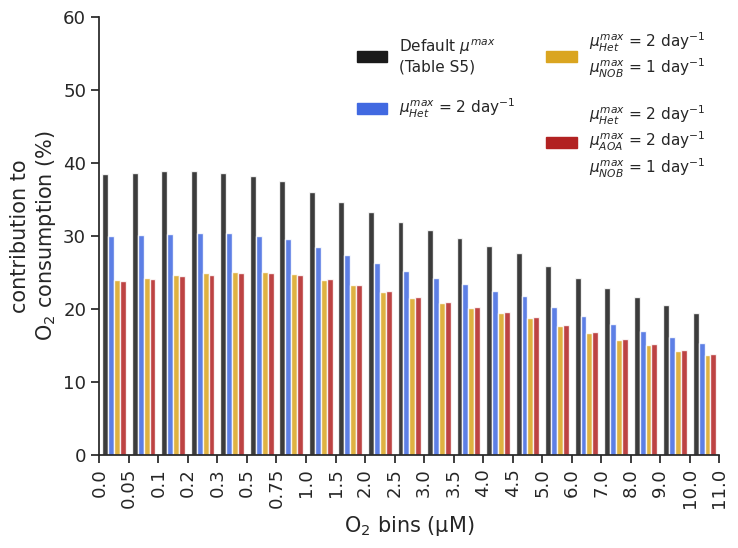

In [13]:

fstic = 13
fslab = 15

cols = ['k', 'royalblue', 'goldenrod', 'firebrick']
lsty = ['-', '-']
alf = 0.85
lwid = [2.0, 2.0]
mar = ['', 'o']
siz = 50


fig = plt.figure(figsize=(8,6))
gs = GridSpec(1,1)

ax1 = plt.subplot(gs[0])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(labelsize=fstic)

ax1.bar(np.arange(len(amz_threshold))-0.3, norm_o2nob_amz, color=cols[0], width=0.2, alpha=alf)
ax1.bar(np.arange(len(amz_threshold))-0.1, het2_o2nob_amz, color=cols[1], width=0.2, alpha=alf)
ax1.bar(np.arange(len(amz_threshold))+0.1, nob1_o2nob_amz, color=cols[2], width=0.2, alpha=alf)
ax1.bar(np.arange(len(amz_threshold))+0.3, all_o2nob_amz, color=cols[3], width=0.2, alpha=alf)
ax1.legend()

ax1.set_ylim(0,60)
ax1.set_xticks(np.arange(len(amz_threshold)+1)-0.5, np.concatenate((np.array([0.0]), amz_threshold)), rotation=90)
ax1.set_xlim(-0.5,20.5)
ax1.set_ylabel('contribution to\nO$_2$ consumption (%)', fontsize=fslab)
ax1.set_xlabel('O$_2$ bins (µM)', fontsize=fslab)

plt.subplots_adjust(bottom=0.15)

import matplotlib.patches as mpatches
p1 = mpatches.Patch(color=cols[0], label='Default $\mu^{max}$\n(Table S5)')
p2 = mpatches.Patch(color=cols[1], label='$\mu_{Het}^{max}$ = 2 day$^{-1}$')
p3 = mpatches.Patch(color=cols[2], label='$\mu_{Het}^{max}$ = 2 day$^{-1}$\n$\mu_{NOB}^{max}$ = 1 day$^{-1}$')
p4 = mpatches.Patch(color=cols[3], label='$\mu_{Het}^{max}$ = 2 day$^{-1}$\n$\mu_{AOA}^{max}$ = 2 day$^{-1}$\n$\mu_{NOB}^{max}$ = 1 day$^{-1}$')
# Add the custom legend to the plot
ax1.legend(handles=[p1,p2,p3,p4], frameon=False, loc='upper right', ncols=2, bbox_to_anchor=(1.0,1), labelspacing=1.5)

print(amz_threshold[6], norm_o2nob_amz[6], amz_threshold[-1], norm_o2nob_amz[-1])
print(amz_threshold[6], het2_o2nob_amz[6], amz_threshold[-1], het2_o2nob_amz[-1])
print(amz_threshold[6], nob1_o2nob_amz[6], amz_threshold[-1], nob1_o2nob_amz[-1])
print(amz_threshold[6], all_o2nob_amz[6], amz_threshold[-1], all_o2nob_amz[-1])


save figure

In [21]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-sensexps.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-sensexps.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-sensexps_transparent.png", dpi=300, transparent=True)

## determine the frequency of occurance of particular NOB contributions (%) to O2 consumption within discrete O2 bounds

In [17]:
%%time

norm_o2nob_amz_01 = []
norm_o2nob_amz_05 = []
norm_o2nob_amz_12 = []
norm_o2nob_amz_25 = []
norm_o2nob_amz_50 = []
norm_o2nob_amz_me = []
norm_o2nob_amz_wm = []
norm_o2nob_amz_75 = []
norm_o2nob_amz_88 = []
norm_o2nob_amz_95 = []
norm_o2nob_amz_99 = []
norm_o2aoa_amz_01 = []
norm_o2aoa_amz_05 = []
norm_o2aoa_amz_12 = []
norm_o2aoa_amz_25 = []
norm_o2aoa_amz_50 = []
norm_o2aoa_amz_me = []
norm_o2aoa_amz_wm = []
norm_o2aoa_amz_75 = []
norm_o2aoa_amz_88 = []
norm_o2aoa_amz_95 = []
norm_o2aoa_amz_99 = []

for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        print("Calculating statistics beneath O2 threshold of %.4f"%(amz))
        o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz, other=np.nan).compute()
        nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz, other=np.nan).compute()
        ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz, other=np.nan).compute()
        volume = (ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    else:
        amzb = amz_threshold[ii-1]
        print("Calculating statistics between O2 thresholds of %.4f and %.4f"%(amzb, amz))
        o2cons = ds['norm_o2cons'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=np.nan).compute()
        nitrox = ds['norm_nitrox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=np.nan).compute()
        ammox = ds['norm_ammox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=np.nan).compute()
        volume = (ds['norm_Hz'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    
    o2nob_01 = o2nob.quantile(0.01)
    o2nob_05 = o2nob.quantile(0.05)
    o2nob_12 = o2nob.quantile(0.12)
    o2nob_25 = o2nob.quantile(0.25)
    o2nob_50 = o2nob.quantile(0.50)
    o2nob_me = o2nob.mean()
    o2nob_wm = o2nob.weighted(volume).mean(skipna=True)
    o2nob_75 = o2nob.quantile(0.75)
    o2nob_88 = o2nob.quantile(0.88)
    o2nob_95 = o2nob.quantile(0.95)
    o2nob_99 = o2nob.quantile(0.99)
    o2aoa_01 = o2aoa.quantile(0.01)
    o2aoa_05 = o2aoa.quantile(0.05)
    o2aoa_12 = o2aoa.quantile(0.12)
    o2aoa_25 = o2aoa.quantile(0.25)
    o2aoa_50 = o2aoa.quantile(0.50)
    o2aoa_me = o2aoa.mean()
    o2aoa_wm = o2aoa.weighted(volume).mean(skipna=True)
    o2aoa_75 = o2aoa.quantile(0.75)
    o2aoa_88 = o2aoa.quantile(0.88)
    o2aoa_95 = o2aoa.quantile(0.95)
    o2aoa_99 = o2aoa.quantile(0.99)
    
    norm_o2nob_amz_01.append(o2nob_01.values)
    norm_o2nob_amz_05.append(o2nob_05.values)
    norm_o2nob_amz_12.append(o2nob_12.values)
    norm_o2nob_amz_25.append(o2nob_25.values)
    norm_o2nob_amz_50.append(o2nob_50.values)
    norm_o2nob_amz_me.append(o2nob_me.values)
    norm_o2nob_amz_wm.append(o2nob_wm.values)
    norm_o2nob_amz_75.append(o2nob_75.values)
    norm_o2nob_amz_88.append(o2nob_88.values)
    norm_o2nob_amz_95.append(o2nob_95.values)
    norm_o2nob_amz_99.append(o2nob_99.values)
    norm_o2aoa_amz_01.append(o2aoa_01.values)
    norm_o2aoa_amz_05.append(o2aoa_05.values)
    norm_o2aoa_amz_12.append(o2aoa_12.values)
    norm_o2aoa_amz_25.append(o2aoa_25.values)
    norm_o2aoa_amz_50.append(o2aoa_50.values)
    norm_o2aoa_amz_me.append(o2aoa_me.values)
    norm_o2aoa_amz_wm.append(o2aoa_wm.values)
    norm_o2aoa_amz_75.append(o2aoa_75.values)
    norm_o2aoa_amz_88.append(o2aoa_88.values)
    norm_o2aoa_amz_95.append(o2aoa_95.values)
    norm_o2aoa_amz_99.append(o2aoa_99.values)

    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of NOB O2 consumption =", norm_o2nob_amz_01[ii], norm_o2nob_amz_05[ii], norm_o2nob_amz_25[ii], norm_o2nob_amz_50[ii], norm_o2nob_amz_75[ii], norm_o2nob_amz_95[ii], norm_o2nob_amz_99[ii])
    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of AOA O2 consumption =", norm_o2aoa_amz_01[ii], norm_o2aoa_amz_05[ii], norm_o2aoa_amz_25[ii], norm_o2aoa_amz_50[ii], norm_o2aoa_amz_75[ii], norm_o2aoa_amz_95[ii], norm_o2aoa_amz_99[ii])
    #print("mean and weighted mean of NOB O2 consumption =", norm_o2nob_amz_me[ii], norm_o2nob_amz_wm[ii])
    #print("mean and weighted mean of AOA O2 consumption =", norm_o2aoa_amz_me[ii], norm_o2aoa_amz_wm[ii])
    
norm_o2nob_amz_01 = np.array(norm_o2nob_amz_01)
norm_o2nob_amz_05 = np.array(norm_o2nob_amz_05)
norm_o2nob_amz_12 = np.array(norm_o2nob_amz_12)
norm_o2nob_amz_25 = np.array(norm_o2nob_amz_25)
norm_o2nob_amz_50 = np.array(norm_o2nob_amz_50)
norm_o2nob_amz_me = np.array(norm_o2nob_amz_me)
norm_o2nob_amz_wm = np.array(norm_o2nob_amz_wm)
norm_o2nob_amz_75 = np.array(norm_o2nob_amz_75)
norm_o2nob_amz_88 = np.array(norm_o2nob_amz_88)
norm_o2nob_amz_95 = np.array(norm_o2nob_amz_95)
norm_o2nob_amz_99 = np.array(norm_o2nob_amz_99)
norm_o2aoa_amz_01 = np.array(norm_o2aoa_amz_01)
norm_o2aoa_amz_05 = np.array(norm_o2aoa_amz_05)
norm_o2aoa_amz_12 = np.array(norm_o2aoa_amz_12)
norm_o2aoa_amz_25 = np.array(norm_o2aoa_amz_25)
norm_o2aoa_amz_50 = np.array(norm_o2aoa_amz_50)
norm_o2aoa_amz_me = np.array(norm_o2aoa_amz_me)
norm_o2aoa_amz_wm = np.array(norm_o2aoa_amz_wm)
norm_o2aoa_amz_75 = np.array(norm_o2aoa_amz_75)
norm_o2aoa_amz_88 = np.array(norm_o2aoa_amz_88)
norm_o2aoa_amz_95 = np.array(norm_o2aoa_amz_95)
norm_o2aoa_amz_99 = np.array(norm_o2aoa_amz_99)




Calculating statistics beneath O2 threshold of 0.0500
Calculating statistics between O2 thresholds of 0.0500 and 0.1000
Calculating statistics between O2 thresholds of 0.1000 and 0.2000
Calculating statistics between O2 thresholds of 0.2000 and 0.3000
Calculating statistics between O2 thresholds of 0.3000 and 0.5000
Calculating statistics between O2 thresholds of 0.5000 and 0.7500
Calculating statistics between O2 thresholds of 0.7500 and 1.0000
Calculating statistics between O2 thresholds of 1.0000 and 1.5000
Calculating statistics between O2 thresholds of 1.5000 and 2.0000
Calculating statistics between O2 thresholds of 2.0000 and 2.5000
Calculating statistics between O2 thresholds of 2.5000 and 3.0000
Calculating statistics between O2 thresholds of 3.0000 and 3.5000
Calculating statistics between O2 thresholds of 3.5000 and 4.0000
Calculating statistics between O2 thresholds of 4.0000 and 4.5000
Calculating statistics between O2 thresholds of 4.5000 and 5.0000
Calculating statistics

In [16]:
%%time

het2_o2nob_amz_01 = []
het2_o2nob_amz_05 = []
het2_o2nob_amz_12 = []
het2_o2nob_amz_25 = []
het2_o2nob_amz_50 = []
het2_o2nob_amz_me = []
het2_o2nob_amz_wm = []
het2_o2nob_amz_75 = []
het2_o2nob_amz_88 = []
het2_o2nob_amz_95 = []
het2_o2nob_amz_99 = []
het2_o2aoa_amz_01 = []
het2_o2aoa_amz_05 = []
het2_o2aoa_amz_12 = []
het2_o2aoa_amz_25 = []
het2_o2aoa_amz_50 = []
het2_o2aoa_amz_me = []
het2_o2aoa_amz_wm = []
het2_o2aoa_amz_75 = []
het2_o2aoa_amz_88 = []
het2_o2aoa_amz_95 = []
het2_o2aoa_amz_99 = []

for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        print("Calculating statistics beneath O2 threshold of %.4f"%(amz))
        o2cons = ds['het2_o2cons'].where(ds['het2_O2'] < amz, other=np.nan).compute()
        nitrox = ds['het2_nitrox'].where(ds['het2_O2'] < amz, other=np.nan).compute()
        ammox = ds['het2_ammox'].where(ds['het2_O2'] < amz, other=np.nan).compute()
        volume = (ds['het2_Hz'].where(ds['het2_O2'] < amz, other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    else:
        amzb = amz_threshold[ii-1]
        print("Calculating statistics between O2 thresholds of %.4f and %.4f"%(amzb, amz))
        o2cons = ds['het2_o2cons'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=np.nan).compute()
        nitrox = ds['het2_nitrox'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=np.nan).compute()
        ammox = ds['het2_ammox'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=np.nan).compute()
        volume = (ds['het2_Hz'].where((ds['het2_O2'] < amz) & (ds['het2_O2'] > amzb), other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    
    o2nob_01 = o2nob.quantile(0.01)
    o2nob_05 = o2nob.quantile(0.05)
    o2nob_12 = o2nob.quantile(0.12)
    o2nob_25 = o2nob.quantile(0.25)
    o2nob_50 = o2nob.quantile(0.50)
    o2nob_me = o2nob.mean()
    o2nob_wm = o2nob.weighted(volume).mean(skipna=True)
    o2nob_75 = o2nob.quantile(0.75)
    o2nob_88 = o2nob.quantile(0.88)
    o2nob_95 = o2nob.quantile(0.95)
    o2nob_99 = o2nob.quantile(0.99)
    o2aoa_01 = o2aoa.quantile(0.01)
    o2aoa_05 = o2aoa.quantile(0.05)
    o2aoa_12 = o2aoa.quantile(0.12)
    o2aoa_25 = o2aoa.quantile(0.25)
    o2aoa_50 = o2aoa.quantile(0.50)
    o2aoa_me = o2aoa.mean()
    o2aoa_wm = o2aoa.weighted(volume).mean(skipna=True)
    o2aoa_75 = o2aoa.quantile(0.75)
    o2aoa_88 = o2aoa.quantile(0.88)
    o2aoa_95 = o2aoa.quantile(0.95)
    o2aoa_99 = o2aoa.quantile(0.99)
    
    het2_o2nob_amz_01.append(o2nob_01.values)
    het2_o2nob_amz_05.append(o2nob_05.values)
    het2_o2nob_amz_12.append(o2nob_12.values)
    het2_o2nob_amz_25.append(o2nob_25.values)
    het2_o2nob_amz_50.append(o2nob_50.values)
    het2_o2nob_amz_me.append(o2nob_me.values)
    het2_o2nob_amz_wm.append(o2nob_wm.values)
    het2_o2nob_amz_75.append(o2nob_75.values)
    het2_o2nob_amz_88.append(o2nob_88.values)
    het2_o2nob_amz_95.append(o2nob_95.values)
    het2_o2nob_amz_99.append(o2nob_99.values)
    het2_o2aoa_amz_01.append(o2aoa_01.values)
    het2_o2aoa_amz_05.append(o2aoa_05.values)
    het2_o2aoa_amz_12.append(o2aoa_12.values)
    het2_o2aoa_amz_25.append(o2aoa_25.values)
    het2_o2aoa_amz_50.append(o2aoa_50.values)
    het2_o2aoa_amz_me.append(o2aoa_me.values)
    het2_o2aoa_amz_wm.append(o2aoa_wm.values)
    het2_o2aoa_amz_75.append(o2aoa_75.values)
    het2_o2aoa_amz_88.append(o2aoa_88.values)
    het2_o2aoa_amz_95.append(o2aoa_95.values)
    het2_o2aoa_amz_99.append(o2aoa_99.values)

    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of NOB O2 consumption =", het2_o2nob_amz_01[ii], het2_o2nob_amz_05[ii], het2_o2nob_amz_25[ii], het2_o2nob_amz_50[ii], het2_o2nob_amz_75[ii], het2_o2nob_amz_95[ii], het2_o2nob_amz_99[ii])
    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of AOA O2 consumption =", het2_o2aoa_amz_01[ii], het2_o2aoa_amz_05[ii], het2_o2aoa_amz_25[ii], het2_o2aoa_amz_50[ii], het2_o2aoa_amz_75[ii], het2_o2aoa_amz_95[ii], het2_o2aoa_amz_99[ii])
    #print("mean and weighted mean of NOB O2 consumption =", het2_o2nob_amz_me[ii], het2_o2nob_amz_wm[ii])
    #print("mean and weighted mean of AOA O2 consumption =", het2_o2aoa_amz_me[ii], het2_o2aoa_amz_wm[ii])
    
het2_o2nob_amz_01 = np.array(het2_o2nob_amz_01)
het2_o2nob_amz_05 = np.array(het2_o2nob_amz_05)
het2_o2nob_amz_12 = np.array(het2_o2nob_amz_12)
het2_o2nob_amz_25 = np.array(het2_o2nob_amz_25)
het2_o2nob_amz_50 = np.array(het2_o2nob_amz_50)
het2_o2nob_amz_me = np.array(het2_o2nob_amz_me)
het2_o2nob_amz_wm = np.array(het2_o2nob_amz_wm)
het2_o2nob_amz_75 = np.array(het2_o2nob_amz_75)
het2_o2nob_amz_88 = np.array(het2_o2nob_amz_88)
het2_o2nob_amz_95 = np.array(het2_o2nob_amz_95)
het2_o2nob_amz_99 = np.array(het2_o2nob_amz_99)
het2_o2aoa_amz_01 = np.array(het2_o2aoa_amz_01)
het2_o2aoa_amz_05 = np.array(het2_o2aoa_amz_05)
het2_o2aoa_amz_12 = np.array(het2_o2aoa_amz_12)
het2_o2aoa_amz_25 = np.array(het2_o2aoa_amz_25)
het2_o2aoa_amz_50 = np.array(het2_o2aoa_amz_50)
het2_o2aoa_amz_me = np.array(het2_o2aoa_amz_me)
het2_o2aoa_amz_wm = np.array(het2_o2aoa_amz_wm)
het2_o2aoa_amz_75 = np.array(het2_o2aoa_amz_75)
het2_o2aoa_amz_88 = np.array(het2_o2aoa_amz_88)
het2_o2aoa_amz_95 = np.array(het2_o2aoa_amz_95)
het2_o2aoa_amz_99 = np.array(het2_o2aoa_amz_99)




Calculating statistics beneath O2 threshold of 0.0500
Calculating statistics between O2 thresholds of 0.0500 and 0.1000
Calculating statistics between O2 thresholds of 0.1000 and 0.2000
Calculating statistics between O2 thresholds of 0.2000 and 0.3000
Calculating statistics between O2 thresholds of 0.3000 and 0.5000
Calculating statistics between O2 thresholds of 0.5000 and 0.7500
Calculating statistics between O2 thresholds of 0.7500 and 1.0000
Calculating statistics between O2 thresholds of 1.0000 and 1.5000
Calculating statistics between O2 thresholds of 1.5000 and 2.0000
Calculating statistics between O2 thresholds of 2.0000 and 2.5000
Calculating statistics between O2 thresholds of 2.5000 and 3.0000
Calculating statistics between O2 thresholds of 3.0000 and 3.5000
Calculating statistics between O2 thresholds of 3.5000 and 4.0000
Calculating statistics between O2 thresholds of 4.0000 and 4.5000
Calculating statistics between O2 thresholds of 4.5000 and 5.0000
Calculating statistics

In [18]:
%%time

nob1_o2nob_amz_01 = []
nob1_o2nob_amz_05 = []
nob1_o2nob_amz_12 = []
nob1_o2nob_amz_25 = []
nob1_o2nob_amz_50 = []
nob1_o2nob_amz_me = []
nob1_o2nob_amz_wm = []
nob1_o2nob_amz_75 = []
nob1_o2nob_amz_88 = []
nob1_o2nob_amz_95 = []
nob1_o2nob_amz_99 = []
nob1_o2aoa_amz_01 = []
nob1_o2aoa_amz_05 = []
nob1_o2aoa_amz_12 = []
nob1_o2aoa_amz_25 = []
nob1_o2aoa_amz_50 = []
nob1_o2aoa_amz_me = []
nob1_o2aoa_amz_wm = []
nob1_o2aoa_amz_75 = []
nob1_o2aoa_amz_88 = []
nob1_o2aoa_amz_95 = []
nob1_o2aoa_amz_99 = []

for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        print("Calculating statistics beneath O2 threshold of %.4f"%(amz))
        o2cons = ds['nob1_o2cons'].where(ds['nob1_O2'] < amz, other=np.nan).compute()
        nitrox = ds['nob1_nitrox'].where(ds['nob1_O2'] < amz, other=np.nan).compute()
        ammox = ds['nob1_ammox'].where(ds['nob1_O2'] < amz, other=np.nan).compute()
        volume = (ds['nob1_Hz'].where(ds['nob1_O2'] < amz, other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    else:
        amzb = amz_threshold[ii-1]
        print("Calculating statistics between O2 thresholds of %.4f and %.4f"%(amzb, amz))
        o2cons = ds['nob1_o2cons'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=np.nan).compute()
        nitrox = ds['nob1_nitrox'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=np.nan).compute()
        ammox = ds['nob1_ammox'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=np.nan).compute()
        volume = (ds['nob1_Hz'].where((ds['nob1_O2'] < amz) & (ds['nob1_O2'] > amzb), other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    
    o2nob_01 = o2nob.quantile(0.01)
    o2nob_05 = o2nob.quantile(0.05)
    o2nob_12 = o2nob.quantile(0.12)
    o2nob_25 = o2nob.quantile(0.25)
    o2nob_50 = o2nob.quantile(0.50)
    o2nob_me = o2nob.mean()
    o2nob_wm = o2nob.weighted(volume).mean(skipna=True)
    o2nob_75 = o2nob.quantile(0.75)
    o2nob_88 = o2nob.quantile(0.88)
    o2nob_95 = o2nob.quantile(0.95)
    o2nob_99 = o2nob.quantile(0.99)
    o2aoa_01 = o2aoa.quantile(0.01)
    o2aoa_05 = o2aoa.quantile(0.05)
    o2aoa_12 = o2aoa.quantile(0.12)
    o2aoa_25 = o2aoa.quantile(0.25)
    o2aoa_50 = o2aoa.quantile(0.50)
    o2aoa_me = o2aoa.mean()
    o2aoa_wm = o2aoa.weighted(volume).mean(skipna=True)
    o2aoa_75 = o2aoa.quantile(0.75)
    o2aoa_88 = o2aoa.quantile(0.88)
    o2aoa_95 = o2aoa.quantile(0.95)
    o2aoa_99 = o2aoa.quantile(0.99)
    
    nob1_o2nob_amz_01.append(o2nob_01.values)
    nob1_o2nob_amz_05.append(o2nob_05.values)
    nob1_o2nob_amz_12.append(o2nob_12.values)
    nob1_o2nob_amz_25.append(o2nob_25.values)
    nob1_o2nob_amz_50.append(o2nob_50.values)
    nob1_o2nob_amz_me.append(o2nob_me.values)
    nob1_o2nob_amz_wm.append(o2nob_wm.values)
    nob1_o2nob_amz_75.append(o2nob_75.values)
    nob1_o2nob_amz_88.append(o2nob_88.values)
    nob1_o2nob_amz_95.append(o2nob_95.values)
    nob1_o2nob_amz_99.append(o2nob_99.values)
    nob1_o2aoa_amz_01.append(o2aoa_01.values)
    nob1_o2aoa_amz_05.append(o2aoa_05.values)
    nob1_o2aoa_amz_12.append(o2aoa_12.values)
    nob1_o2aoa_amz_25.append(o2aoa_25.values)
    nob1_o2aoa_amz_50.append(o2aoa_50.values)
    nob1_o2aoa_amz_me.append(o2aoa_me.values)
    nob1_o2aoa_amz_wm.append(o2aoa_wm.values)
    nob1_o2aoa_amz_75.append(o2aoa_75.values)
    nob1_o2aoa_amz_88.append(o2aoa_88.values)
    nob1_o2aoa_amz_95.append(o2aoa_95.values)
    nob1_o2aoa_amz_99.append(o2aoa_99.values)

    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of NOB O2 consumption =", nob1_o2nob_amz_01[ii], nob1_o2nob_amz_05[ii], nob1_o2nob_amz_25[ii], nob1_o2nob_amz_50[ii], nob1_o2nob_amz_75[ii], nob1_o2nob_amz_95[ii], nob1_o2nob_amz_99[ii])
    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of AOA O2 consumption =", nob1_o2aoa_amz_01[ii], nob1_o2aoa_amz_05[ii], nob1_o2aoa_amz_25[ii], nob1_o2aoa_amz_50[ii], nob1_o2aoa_amz_75[ii], nob1_o2aoa_amz_95[ii], nob1_o2aoa_amz_99[ii])
    #print("mean and weighted mean of NOB O2 consumption =", nob1_o2nob_amz_me[ii], nob1_o2nob_amz_wm[ii])
    #print("mean and weighted mean of AOA O2 consumption =", nob1_o2aoa_amz_me[ii], nob1_o2aoa_amz_wm[ii])
    
nob1_o2nob_amz_01 = np.array(nob1_o2nob_amz_01)
nob1_o2nob_amz_05 = np.array(nob1_o2nob_amz_05)
nob1_o2nob_amz_12 = np.array(nob1_o2nob_amz_12)
nob1_o2nob_amz_25 = np.array(nob1_o2nob_amz_25)
nob1_o2nob_amz_50 = np.array(nob1_o2nob_amz_50)
nob1_o2nob_amz_me = np.array(nob1_o2nob_amz_me)
nob1_o2nob_amz_wm = np.array(nob1_o2nob_amz_wm)
nob1_o2nob_amz_75 = np.array(nob1_o2nob_amz_75)
nob1_o2nob_amz_88 = np.array(nob1_o2nob_amz_88)
nob1_o2nob_amz_95 = np.array(nob1_o2nob_amz_95)
nob1_o2nob_amz_99 = np.array(nob1_o2nob_amz_99)
nob1_o2aoa_amz_01 = np.array(nob1_o2aoa_amz_01)
nob1_o2aoa_amz_05 = np.array(nob1_o2aoa_amz_05)
nob1_o2aoa_amz_12 = np.array(nob1_o2aoa_amz_12)
nob1_o2aoa_amz_25 = np.array(nob1_o2aoa_amz_25)
nob1_o2aoa_amz_50 = np.array(nob1_o2aoa_amz_50)
nob1_o2aoa_amz_me = np.array(nob1_o2aoa_amz_me)
nob1_o2aoa_amz_wm = np.array(nob1_o2aoa_amz_wm)
nob1_o2aoa_amz_75 = np.array(nob1_o2aoa_amz_75)
nob1_o2aoa_amz_88 = np.array(nob1_o2aoa_amz_88)
nob1_o2aoa_amz_95 = np.array(nob1_o2aoa_amz_95)
nob1_o2aoa_amz_99 = np.array(nob1_o2aoa_amz_99)




Calculating statistics beneath O2 threshold of 0.0500
Calculating statistics between O2 thresholds of 0.0500 and 0.1000
Calculating statistics between O2 thresholds of 0.1000 and 0.2000
Calculating statistics between O2 thresholds of 0.2000 and 0.3000
Calculating statistics between O2 thresholds of 0.3000 and 0.5000
Calculating statistics between O2 thresholds of 0.5000 and 0.7500
Calculating statistics between O2 thresholds of 0.7500 and 1.0000
Calculating statistics between O2 thresholds of 1.0000 and 1.5000
Calculating statistics between O2 thresholds of 1.5000 and 2.0000
Calculating statistics between O2 thresholds of 2.0000 and 2.5000
Calculating statistics between O2 thresholds of 2.5000 and 3.0000
Calculating statistics between O2 thresholds of 3.0000 and 3.5000
Calculating statistics between O2 thresholds of 3.5000 and 4.0000
Calculating statistics between O2 thresholds of 4.0000 and 4.5000
Calculating statistics between O2 thresholds of 4.5000 and 5.0000
Calculating statistics

In [19]:
%%time

all_o2nob_amz_01 = []
all_o2nob_amz_05 = []
all_o2nob_amz_12 = []
all_o2nob_amz_25 = []
all_o2nob_amz_50 = []
all_o2nob_amz_me = []
all_o2nob_amz_wm = []
all_o2nob_amz_75 = []
all_o2nob_amz_88 = []
all_o2nob_amz_95 = []
all_o2nob_amz_99 = []
all_o2aoa_amz_01 = []
all_o2aoa_amz_05 = []
all_o2aoa_amz_12 = []
all_o2aoa_amz_25 = []
all_o2aoa_amz_50 = []
all_o2aoa_amz_me = []
all_o2aoa_amz_wm = []
all_o2aoa_amz_75 = []
all_o2aoa_amz_88 = []
all_o2aoa_amz_95 = []
all_o2aoa_amz_99 = []

for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        print("Calculating statistics beneath O2 threshold of %.4f"%(amz))
        o2cons = ds['all_o2cons'].where(ds['all_O2'] < amz, other=np.nan).compute()
        nitrox = ds['all_nitrox'].where(ds['all_O2'] < amz, other=np.nan).compute()
        ammox = ds['all_ammox'].where(ds['all_O2'] < amz, other=np.nan).compute()
        volume = (ds['all_Hz'].where(ds['all_O2'] < amz, other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    else:
        amzb = amz_threshold[ii-1]
        print("Calculating statistics between O2 thresholds of %.4f and %.4f"%(amzb, amz))
        o2cons = ds['all_o2cons'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=np.nan).compute()
        nitrox = ds['all_nitrox'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=np.nan).compute()
        ammox = ds['all_ammox'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=np.nan).compute()
        volume = (ds['all_Hz'].where((ds['all_O2'] < amz) & (ds['all_O2'] > amzb), other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    
    o2nob_01 = o2nob.quantile(0.01)
    o2nob_05 = o2nob.quantile(0.05)
    o2nob_12 = o2nob.quantile(0.12)
    o2nob_25 = o2nob.quantile(0.25)
    o2nob_50 = o2nob.quantile(0.50)
    o2nob_me = o2nob.mean()
    o2nob_wm = o2nob.weighted(volume).mean(skipna=True)
    o2nob_75 = o2nob.quantile(0.75)
    o2nob_88 = o2nob.quantile(0.88)
    o2nob_95 = o2nob.quantile(0.95)
    o2nob_99 = o2nob.quantile(0.99)
    o2aoa_01 = o2aoa.quantile(0.01)
    o2aoa_05 = o2aoa.quantile(0.05)
    o2aoa_12 = o2aoa.quantile(0.12)
    o2aoa_25 = o2aoa.quantile(0.25)
    o2aoa_50 = o2aoa.quantile(0.50)
    o2aoa_me = o2aoa.mean()
    o2aoa_wm = o2aoa.weighted(volume).mean(skipna=True)
    o2aoa_75 = o2aoa.quantile(0.75)
    o2aoa_88 = o2aoa.quantile(0.88)
    o2aoa_95 = o2aoa.quantile(0.95)
    o2aoa_99 = o2aoa.quantile(0.99)
    
    all_o2nob_amz_01.append(o2nob_01.values)
    all_o2nob_amz_05.append(o2nob_05.values)
    all_o2nob_amz_12.append(o2nob_12.values)
    all_o2nob_amz_25.append(o2nob_25.values)
    all_o2nob_amz_50.append(o2nob_50.values)
    all_o2nob_amz_me.append(o2nob_me.values)
    all_o2nob_amz_wm.append(o2nob_wm.values)
    all_o2nob_amz_75.append(o2nob_75.values)
    all_o2nob_amz_88.append(o2nob_88.values)
    all_o2nob_amz_95.append(o2nob_95.values)
    all_o2nob_amz_99.append(o2nob_99.values)
    all_o2aoa_amz_01.append(o2aoa_01.values)
    all_o2aoa_amz_05.append(o2aoa_05.values)
    all_o2aoa_amz_12.append(o2aoa_12.values)
    all_o2aoa_amz_25.append(o2aoa_25.values)
    all_o2aoa_amz_50.append(o2aoa_50.values)
    all_o2aoa_amz_me.append(o2aoa_me.values)
    all_o2aoa_amz_wm.append(o2aoa_wm.values)
    all_o2aoa_amz_75.append(o2aoa_75.values)
    all_o2aoa_amz_88.append(o2aoa_88.values)
    all_o2aoa_amz_95.append(o2aoa_95.values)
    all_o2aoa_amz_99.append(o2aoa_99.values)

    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of NOB O2 consumption =", all_o2nob_amz_01[ii], all_o2nob_amz_05[ii], all_o2nob_amz_25[ii], all_o2nob_amz_50[ii], all_o2nob_amz_75[ii], all_o2nob_amz_95[ii], all_o2nob_amz_99[ii])
    #print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of AOA O2 consumption =", all_o2aoa_amz_01[ii], all_o2aoa_amz_05[ii], all_o2aoa_amz_25[ii], all_o2aoa_amz_50[ii], all_o2aoa_amz_75[ii], all_o2aoa_amz_95[ii], all_o2aoa_amz_99[ii])
    #print("mean and weighted mean of NOB O2 consumption =", all_o2nob_amz_me[ii], all_o2nob_amz_wm[ii])
    #print("mean and weighted mean of AOA O2 consumption =", all_o2aoa_amz_me[ii], all_o2aoa_amz_wm[ii])
    
all_o2nob_amz_01 = np.array(all_o2nob_amz_01)
all_o2nob_amz_05 = np.array(all_o2nob_amz_05)
all_o2nob_amz_12 = np.array(all_o2nob_amz_12)
all_o2nob_amz_25 = np.array(all_o2nob_amz_25)
all_o2nob_amz_50 = np.array(all_o2nob_amz_50)
all_o2nob_amz_me = np.array(all_o2nob_amz_me)
all_o2nob_amz_wm = np.array(all_o2nob_amz_wm)
all_o2nob_amz_75 = np.array(all_o2nob_amz_75)
all_o2nob_amz_88 = np.array(all_o2nob_amz_88)
all_o2nob_amz_95 = np.array(all_o2nob_amz_95)
all_o2nob_amz_99 = np.array(all_o2nob_amz_99)
all_o2aoa_amz_01 = np.array(all_o2aoa_amz_01)
all_o2aoa_amz_05 = np.array(all_o2aoa_amz_05)
all_o2aoa_amz_12 = np.array(all_o2aoa_amz_12)
all_o2aoa_amz_25 = np.array(all_o2aoa_amz_25)
all_o2aoa_amz_50 = np.array(all_o2aoa_amz_50)
all_o2aoa_amz_me = np.array(all_o2aoa_amz_me)
all_o2aoa_amz_wm = np.array(all_o2aoa_amz_wm)
all_o2aoa_amz_75 = np.array(all_o2aoa_amz_75)
all_o2aoa_amz_88 = np.array(all_o2aoa_amz_88)
all_o2aoa_amz_95 = np.array(all_o2aoa_amz_95)
all_o2aoa_amz_99 = np.array(all_o2aoa_amz_99)




Calculating statistics beneath O2 threshold of 0.0500
Calculating statistics between O2 thresholds of 0.0500 and 0.1000
Calculating statistics between O2 thresholds of 0.1000 and 0.2000
Calculating statistics between O2 thresholds of 0.2000 and 0.3000
Calculating statistics between O2 thresholds of 0.3000 and 0.5000
Calculating statistics between O2 thresholds of 0.5000 and 0.7500
Calculating statistics between O2 thresholds of 0.7500 and 1.0000
Calculating statistics between O2 thresholds of 1.0000 and 1.5000
Calculating statistics between O2 thresholds of 1.5000 and 2.0000
Calculating statistics between O2 thresholds of 2.0000 and 2.5000
Calculating statistics between O2 thresholds of 2.5000 and 3.0000
Calculating statistics between O2 thresholds of 3.0000 and 3.5000
Calculating statistics between O2 thresholds of 3.5000 and 4.0000
Calculating statistics between O2 thresholds of 4.0000 and 4.5000
Calculating statistics between O2 thresholds of 4.5000 and 5.0000
Calculating statistics

### get the observations

In [20]:
beman = pd.read_excel("/home/pbuchanan/analysis_nox/Beman2021_O2consumption.xlsx", engine='openpyxl')


### see how where the observations for a particular O2 concentration fall within the model predicted frequencies

In [21]:
# count how many fall within the different bounds of the model

count_in_00_01 = 0
count_in_01_05 = 0
count_in_05_12 = 0
count_in_12_25 = 0
count_in_25_50 = 0
count_in_50_75 = 0
count_in_75_88 = 0
count_in_88_95 = 0
count_in_95_99 = 0
count_in_99_100 = 0

print("count where the observations fall within the different bounds of the default model")
for ii,ox in enumerate(amz_threshold):
    if ii == 0:
        continue
    tmp = beman[beman['O2'] < ox]
    tmp = tmp[tmp['O2'] > amz_threshold[ii-1]]
    if len(tmp) == 0.0:
        continue
    else:
        for nox in tmp['Nox_consump']:
            #print(ii, ox, nox)
    
            if nox < norm_o2nob_amz_01[ii]:
                count_in_00_01 += 1
            if nox >= norm_o2nob_amz_01[ii] and nox < norm_o2nob_amz_05[ii]:
                count_in_01_05 += 1
            if nox >= norm_o2nob_amz_05[ii] and nox < norm_o2nob_amz_12[ii]:
                count_in_05_12 += 1
            if nox >= norm_o2nob_amz_12[ii] and nox < norm_o2nob_amz_25[ii]:
                count_in_12_25 += 1
            if nox >= norm_o2nob_amz_25[ii] and nox < norm_o2nob_amz_50[ii]:
                count_in_25_50 += 1
            if nox >= norm_o2nob_amz_50[ii] and nox < norm_o2nob_amz_75[ii]:
                count_in_50_75 += 1
            if nox >= norm_o2nob_amz_75[ii] and nox < norm_o2nob_amz_88[ii]:
                count_in_75_88 += 1
            if nox >= norm_o2nob_amz_88[ii] and nox < norm_o2nob_amz_95[ii]:
                count_in_88_95 += 1
            if nox >= norm_o2nob_amz_95[ii] and nox < norm_o2nob_amz_99[ii]:
                count_in_95_99 += 1
            if nox >= norm_o2nob_amz_99[ii]:
                count_in_99_100 += 1


count_obs_in_norm_range = np.array([count_in_00_01, count_in_01_05, count_in_05_12, count_in_12_25, count_in_25_50, count_in_50_75, count_in_75_88, count_in_88_95, count_in_95_99, count_in_99_100])


print("count where the observations fall within the different bounds of the mumax(Het)==2.0 model")
count_in_00_01 = 0
count_in_01_05 = 0
count_in_05_12 = 0
count_in_12_25 = 0
count_in_25_50 = 0
count_in_50_75 = 0
count_in_75_88 = 0
count_in_88_95 = 0
count_in_95_99 = 0
count_in_99_100 = 0

for ii,ox in enumerate(amz_threshold):
    if ii == 0:
        continue
    tmp = beman[beman['O2'] < ox]
    tmp = tmp[tmp['O2'] > amz_threshold[ii-1]]
    if len(tmp) == 0.0:
        continue
    else:
        for nox in tmp['Nox_consump']:
            #print(ii, ox, nox)
    
            if nox < het2_o2nob_amz_01[ii]:
                count_in_00_01 += 1
            if nox >= het2_o2nob_amz_01[ii] and nox < het2_o2nob_amz_05[ii]:
                count_in_01_05 += 1
            if nox >= het2_o2nob_amz_05[ii] and nox < het2_o2nob_amz_12[ii]:
                count_in_05_12 += 1
            if nox >= het2_o2nob_amz_12[ii] and nox < het2_o2nob_amz_25[ii]:
                count_in_12_25 += 1
            if nox >= het2_o2nob_amz_25[ii] and nox < het2_o2nob_amz_50[ii]:
                count_in_25_50 += 1
            if nox >= het2_o2nob_amz_50[ii] and nox < het2_o2nob_amz_75[ii]:
                count_in_50_75 += 1
            if nox >= het2_o2nob_amz_75[ii] and nox < het2_o2nob_amz_88[ii]:
                count_in_75_88 += 1
            if nox >= het2_o2nob_amz_88[ii] and nox < het2_o2nob_amz_95[ii]:
                count_in_88_95 += 1
            if nox >= het2_o2nob_amz_95[ii] and nox < het2_o2nob_amz_99[ii]:
                count_in_95_99 += 1
            if nox >= het2_o2nob_amz_99[ii]:
                count_in_99_100 += 1


count_obs_in_het2_range = np.array([count_in_00_01, count_in_01_05, count_in_05_12, count_in_12_25, count_in_25_50, count_in_50_75, count_in_75_88, count_in_88_95, count_in_95_99, count_in_99_100])


print("count where the observations fall within the different bounds of the mumax(Het)==2.0 & mumax(NOB)==1.0 model")
count_in_00_01 = 0
count_in_01_05 = 0
count_in_05_12 = 0
count_in_12_25 = 0
count_in_25_50 = 0
count_in_50_75 = 0
count_in_75_88 = 0
count_in_88_95 = 0
count_in_95_99 = 0
count_in_99_100 = 0

for ii,ox in enumerate(amz_threshold):
    if ii == 0:
        continue
    tmp = beman[beman['O2'] < ox]
    tmp = tmp[tmp['O2'] > amz_threshold[ii-1]]
    if len(tmp) == 0.0:
        continue
    else:
        for nox in tmp['Nox_consump']:
            #print(ii, ox, nox)
    
            if nox < nob1_o2nob_amz_01[ii]:
                count_in_00_01 += 1
            if nox >= nob1_o2nob_amz_01[ii] and nox < nob1_o2nob_amz_05[ii]:
                count_in_01_05 += 1
            if nox >= nob1_o2nob_amz_05[ii] and nox < nob1_o2nob_amz_12[ii]:
                count_in_05_12 += 1
            if nox >= nob1_o2nob_amz_12[ii] and nox < nob1_o2nob_amz_25[ii]:
                count_in_12_25 += 1
            if nox >= nob1_o2nob_amz_25[ii] and nox < nob1_o2nob_amz_50[ii]:
                count_in_25_50 += 1
            if nox >= nob1_o2nob_amz_50[ii] and nox < nob1_o2nob_amz_75[ii]:
                count_in_50_75 += 1
            if nox >= nob1_o2nob_amz_75[ii] and nox < nob1_o2nob_amz_88[ii]:
                count_in_75_88 += 1
            if nox >= nob1_o2nob_amz_88[ii] and nox < nob1_o2nob_amz_95[ii]:
                count_in_88_95 += 1
            if nox >= nob1_o2nob_amz_95[ii] and nox < nob1_o2nob_amz_99[ii]:
                count_in_95_99 += 1
            if nox >= nob1_o2nob_amz_99[ii]:
                count_in_99_100 += 1


count_obs_in_nob1_range = np.array([count_in_00_01, count_in_01_05, count_in_05_12, count_in_12_25, count_in_25_50, count_in_50_75, count_in_75_88, count_in_88_95, count_in_95_99, count_in_99_100])


print("count where the observations fall within the different bounds of the mumax(Het)==2.0, mumax(AOA)==2.0 & mumax(NOB)==1.0 model")
count_in_00_01 = 0
count_in_01_05 = 0
count_in_05_12 = 0
count_in_12_25 = 0
count_in_25_50 = 0
count_in_50_75 = 0
count_in_75_88 = 0
count_in_88_95 = 0
count_in_95_99 = 0
count_in_99_100 = 0

for ii,ox in enumerate(amz_threshold):
    if ii == 0:
        continue
    tmp = beman[beman['O2'] < ox]
    tmp = tmp[tmp['O2'] > amz_threshold[ii-1]]
    if len(tmp) == 0.0:
        continue
    else:
        for nox in tmp['Nox_consump']:
            #print(ii, ox, nox)
    
            if nox < all_o2nob_amz_01[ii]:
                count_in_00_01 += 1
            if nox >= all_o2nob_amz_01[ii] and nox < all_o2nob_amz_05[ii]:
                count_in_01_05 += 1
            if nox >= all_o2nob_amz_05[ii] and nox < all_o2nob_amz_12[ii]:
                count_in_05_12 += 1
            if nox >= all_o2nob_amz_12[ii] and nox < all_o2nob_amz_25[ii]:
                count_in_12_25 += 1
            if nox >= all_o2nob_amz_25[ii] and nox < all_o2nob_amz_50[ii]:
                count_in_25_50 += 1
            if nox >= all_o2nob_amz_50[ii] and nox < all_o2nob_amz_75[ii]:
                count_in_50_75 += 1
            if nox >= all_o2nob_amz_75[ii] and nox < all_o2nob_amz_88[ii]:
                count_in_75_88 += 1
            if nox >= all_o2nob_amz_88[ii] and nox < all_o2nob_amz_95[ii]:
                count_in_88_95 += 1
            if nox >= all_o2nob_amz_95[ii] and nox < all_o2nob_amz_99[ii]:
                count_in_95_99 += 1
            if nox >= all_o2nob_amz_99[ii]:
                count_in_99_100 += 1


count_obs_in_all_range = np.array([count_in_00_01, count_in_01_05, count_in_05_12, count_in_12_25, count_in_25_50, count_in_50_75, count_in_75_88, count_in_88_95, count_in_95_99, count_in_99_100])




count where the observations fall within the different bounds of the default model
count where the observations fall within the different bounds of the mumax(Het)==2.0 model
count where the observations fall within the different bounds of the mumax(Het)==2.0 & mumax(NOB)==1.0 model
count where the observations fall within the different bounds of the mumax(Het)==2.0, mumax(AOA)==2.0 & mumax(NOB)==1.0 model


### plot the outcomes

35
35
35
35


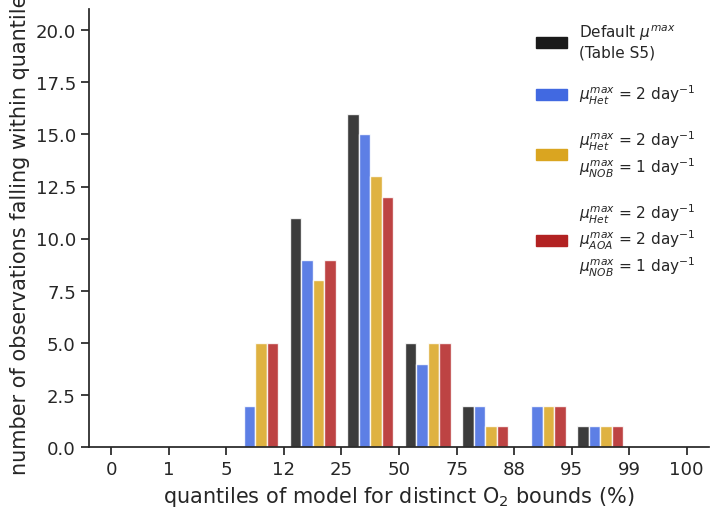

In [26]:
fstic = 13
fslab = 15


cols = ['k', 'royalblue', 'goldenrod', 'firebrick']
lsty = ['-', '-']
alf = 0.85
lwid = [2.0, 2.0]
mar = ['', 'o']
siz = 50


fig = plt.figure(figsize=(8,6))
gs = GridSpec(1,1)

ax1 = plt.subplot(gs[0])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(labelsize=fstic)


ax1.bar(np.arange(len(count_obs_in_norm_range))-0.8, count_obs_in_norm_range, color=cols[0], width=0.2, alpha=alf)
ax1.bar(np.arange(len(count_obs_in_het2_range))-0.6, count_obs_in_het2_range, color=cols[1], width=0.2, alpha=alf)
ax1.bar(np.arange(len(count_obs_in_nob1_range))-0.4, count_obs_in_nob1_range, color=cols[2], width=0.2, alpha=alf)
ax1.bar(np.arange(len(count_obs_in_all_range))-0.2, count_obs_in_all_range, color=cols[3], width=0.2, alpha=alf)

xlabs = np.array([0, 1, 5, 12, 25, 50, 75, 88, 95, 99, 100])

ax1.set_ylim(0,21)
ax1.set_xticks(np.arange(len(count_obs_in_norm_range)+1)-1, xlabs)
ax1.set_ylabel('number of observations falling within quantiles', fontsize=fslab)
ax1.set_xlabel('quantiles of model for distinct O$_2$ bounds (%)', fontsize=fslab)
plt.subplots_adjust(bottom=0.15)

import matplotlib.patches as mpatches
p1 = mpatches.Patch(color=cols[0], label='Default $\mu^{max}$\n(Table S5)')
p2 = mpatches.Patch(color=cols[1], label='$\mu_{Het}^{max}$ = 2 day$^{-1}$')
p3 = mpatches.Patch(color=cols[2], label='$\mu_{Het}^{max}$ = 2 day$^{-1}$\n$\mu_{NOB}^{max}$ = 1 day$^{-1}$')
p4 = mpatches.Patch(color=cols[3], label='$\mu_{Het}^{max}$ = 2 day$^{-1}$\n$\mu_{AOA}^{max}$ = 2 day$^{-1}$\n$\mu_{NOB}^{max}$ = 1 day$^{-1}$')
# Add the custom legend to the plot
ax1.legend(handles=[p1,p2,p3,p4], frameon=False, loc='upper right', ncols=1, bbox_to_anchor=(1.0,1), labelspacing=1.5)

print(np.sum(count_obs_in_norm_range))
print(np.sum(count_obs_in_het2_range))
print(np.sum(count_obs_in_nob1_range))
print(np.sum(count_obs_in_all_range))



In [27]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-obscount-sensexps.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-obscount-sensexps.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-obscount-sensexps_transparent.png", dpi=300, transparent=True)

## extract longitudinal and latitudinal sections

In [11]:

longitude = 275
lon1 = longitude-0.5
lon2 = longitude+0.5

norm_ytransect_o2 = ds["norm_O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_o2cons = ds["norm_o2cons"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_no2 = ds["norm_NO2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_nox = ds["norm_nitrox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_nhx = ds["norm_ammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_amx = ds["norm_anammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_den = ds["norm_no2red"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_nob = ds["norm_NOB"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_aoa = ds["norm_AOA"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_aox = ds["norm_AOX"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_nio = ds["norm_NIO"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_nar = ds["norm_NAR"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_nobmu = ds["norm_NOBmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_aoamu = ds["norm_AOAmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_aoxmu = ds["norm_AOXmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_niomu = ds["norm_NIOmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_narmu = ds["norm_NARmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_y = ds["lat_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_z = ds["norm_zr"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
### broadcast ytransect_y (lats) across the depth axis
norm_ytransect_y = np.repeat(norm_ytransect_y.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
norm_ytransect_o2 = norm_ytransect_o2.where(norm_ytransect_o2 > 0.0, other=0.0)
norm_ytransect_no2 = norm_ytransect_no2.where(norm_ytransect_no2 > 0.0, other=0.0)
norm_ytransect_nob = norm_ytransect_nob.where(norm_ytransect_nob > 0.0, other=0.0)
norm_ytransect_aoa = norm_ytransect_aoa.where(norm_ytransect_aoa > 0.0, other=0.0)
norm_ytransect_aox = norm_ytransect_aox.where(norm_ytransect_aox > 0.0, other=0.0)
norm_ytransect_nio = norm_ytransect_nio.where(norm_ytransect_nio > 0.0, other=0.0)

het2_ytransect_o2 = ds["het2_O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_o2cons = ds["het2_o2cons"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_no2 = ds["het2_NO2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_nox = ds["het2_nitrox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_nhx = ds["het2_ammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_amx = ds["het2_anammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_den = ds["het2_no2red"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_nob = ds["het2_NOB"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_aoa = ds["het2_AOA"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_aox = ds["het2_AOX"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_nio = ds["het2_NIO"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_nar = ds["het2_NAR"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_nobmu = ds["het2_NOBmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_aoamu = ds["het2_AOAmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_aoxmu = ds["het2_AOXmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_niomu = ds["het2_NIOmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_narmu = ds["het2_NARmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_y = ds["lat_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
het2_ytransect_z = ds["het2_zr"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
### broadcast ytransect_y (lats) across the depth axis
het2_ytransect_y = np.repeat(het2_ytransect_y.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
het2_ytransect_o2 = het2_ytransect_o2.where(het2_ytransect_o2 > 0.0, other=0.0)
het2_ytransect_no2 = het2_ytransect_no2.where(het2_ytransect_no2 > 0.0, other=0.0)
het2_ytransect_nob = het2_ytransect_nob.where(het2_ytransect_nob > 0.0, other=0.0)
het2_ytransect_aoa = het2_ytransect_aoa.where(het2_ytransect_aoa > 0.0, other=0.0)
het2_ytransect_aox = het2_ytransect_aox.where(het2_ytransect_aox > 0.0, other=0.0)
het2_ytransect_nio = het2_ytransect_nio.where(het2_ytransect_nio > 0.0, other=0.0)

nob1_ytransect_o2 = ds["nob1_O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_o2cons = ds["nob1_o2cons"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_no2 = ds["nob1_NO2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_nox = ds["nob1_nitrox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_nhx = ds["nob1_ammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_amx = ds["nob1_anammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_den = ds["nob1_no2red"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_nob = ds["nob1_NOB"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_aoa = ds["nob1_AOA"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_aox = ds["nob1_AOX"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_nio = ds["nob1_NIO"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_nar = ds["nob1_NAR"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_nobmu = ds["nob1_NOBmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_aoamu = ds["nob1_AOAmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_aoxmu = ds["nob1_AOXmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_niomu = ds["nob1_NIOmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_narmu = ds["nob1_NARmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_y = ds["lat_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
nob1_ytransect_z = ds["nob1_zr"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
### broadcast ytransect_y (lats) across the depth axis
nob1_ytransect_y = np.repeat(nob1_ytransect_y.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
nob1_ytransect_o2 = nob1_ytransect_o2.where(nob1_ytransect_o2 > 0.0, other=0.0)
nob1_ytransect_no2 = nob1_ytransect_no2.where(nob1_ytransect_no2 > 0.0, other=0.0)
nob1_ytransect_nob = nob1_ytransect_nob.where(nob1_ytransect_nob > 0.0, other=0.0)
nob1_ytransect_aoa = nob1_ytransect_aoa.where(nob1_ytransect_aoa > 0.0, other=0.0)
nob1_ytransect_aox = nob1_ytransect_aox.where(nob1_ytransect_aox > 0.0, other=0.0)
nob1_ytransect_nio = nob1_ytransect_nio.where(nob1_ytransect_nio > 0.0, other=0.0)

all_ytransect_o2 = ds["all_O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_o2cons = ds["all_o2cons"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_no2 = ds["all_NO2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_nox = ds["all_nitrox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_nhx = ds["all_ammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_amx = ds["all_anammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_den = ds["all_no2red"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_nob = ds["all_NOB"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_aoa = ds["all_AOA"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_aox = ds["all_AOX"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_nio = ds["all_NIO"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_nar = ds["all_NAR"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_nobmu = ds["all_NOBmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_aoamu = ds["all_AOAmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_aoxmu = ds["all_AOXmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_niomu = ds["all_NIOmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_narmu = ds["all_NARmu"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_y = ds["lat_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
all_ytransect_z = ds["all_zr"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
### broadcast ytransect_y (lats) across the depth axis
all_ytransect_y = np.repeat(all_ytransect_y.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
all_ytransect_o2 = all_ytransect_o2.where(all_ytransect_o2 > 0.0, other=0.0)
all_ytransect_no2 = all_ytransect_no2.where(all_ytransect_no2 > 0.0, other=0.0)
all_ytransect_nob = all_ytransect_nob.where(all_ytransect_nob > 0.0, other=0.0)
all_ytransect_aoa = all_ytransect_aoa.where(all_ytransect_aoa > 0.0, other=0.0)
all_ytransect_aox = all_ytransect_aox.where(all_ytransect_aox > 0.0, other=0.0)
all_ytransect_nio = all_ytransect_nio.where(all_ytransect_nio > 0.0, other=0.0)

latitude = -8
lat1 = latitude-0.5
lat2 = latitude+0.5

norm_xtransect_o2 = ds["norm_O2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_o2cons = ds["norm_o2cons"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_no2 = ds["norm_NO2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_nox = ds["norm_nitrox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_nhx = ds["norm_ammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_amx = ds["norm_anammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_den = ds["norm_no2red"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_nob = ds["norm_NOB"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_aoa = ds["norm_AOA"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_aox = ds["norm_AOX"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_nio = ds["norm_NIO"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_x = ds["lon_rho"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_z = ds["norm_zr"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
### broadcast xtransect_y (lats) across the depth axis
norm_xtransect_x = np.repeat(norm_xtransect_x.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
norm_xtransect_o2 = norm_xtransect_o2.where(norm_xtransect_o2 > 0.0, other=0.0)
norm_xtransect_no2 = norm_xtransect_no2.where(norm_xtransect_no2 > 0.0, other=0.0)
norm_xtransect_nob = norm_xtransect_nob.where(norm_xtransect_nob > 0.0, other=0.0)
norm_xtransect_aoa = norm_xtransect_aoa.where(norm_xtransect_aoa > 0.0, other=0.0)
norm_xtransect_nio = norm_xtransect_nio.where(norm_xtransect_nio > 0.0, other=0.0)
norm_xtransect_aox = norm_xtransect_aox.where(norm_xtransect_aox > 0.0, other=0.0)

het2_xtransect_o2 = ds["het2_O2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_o2cons = ds["het2_o2cons"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_no2 = ds["het2_NO2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_nox = ds["het2_nitrox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_nhx = ds["het2_ammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_amx = ds["het2_anammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_den = ds["het2_no2red"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_nob = ds["het2_NOB"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_aoa = ds["het2_AOA"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_aox = ds["het2_AOX"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_nio = ds["het2_NIO"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_x = ds["lon_rho"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
het2_xtransect_z = ds["het2_zr"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
### broadcast xtransect_y (lats) across the depth axis
het2_xtransect_x = np.repeat(het2_xtransect_x.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
het2_xtransect_o2 = het2_xtransect_o2.where(het2_xtransect_o2 > 0.0, other=0.0)
het2_xtransect_no2 = het2_xtransect_no2.where(het2_xtransect_no2 > 0.0, other=0.0)
het2_xtransect_nob = het2_xtransect_nob.where(het2_xtransect_nob > 0.0, other=0.0)
het2_xtransect_aoa = het2_xtransect_aoa.where(het2_xtransect_aoa > 0.0, other=0.0)
het2_xtransect_nio = het2_xtransect_nio.where(het2_xtransect_nio > 0.0, other=0.0)
het2_xtransect_aox = het2_xtransect_aox.where(het2_xtransect_aox > 0.0, other=0.0)

nob1_xtransect_o2 = ds["nob1_O2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_o2cons = ds["nob1_o2cons"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_no2 = ds["nob1_NO2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_nox = ds["nob1_nitrox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_nhx = ds["nob1_ammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_amx = ds["nob1_anammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_den = ds["nob1_no2red"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_nob = ds["nob1_NOB"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_aoa = ds["nob1_AOA"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_aox = ds["nob1_AOX"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_nio = ds["nob1_NIO"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_x = ds["lon_rho"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
nob1_xtransect_z = ds["nob1_zr"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
### broadcast xtransect_y (lats) across the depth axis
nob1_xtransect_x = np.repeat(nob1_xtransect_x.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
nob1_xtransect_o2 = nob1_xtransect_o2.where(nob1_xtransect_o2 > 0.0, other=0.0)
nob1_xtransect_no2 = nob1_xtransect_no2.where(nob1_xtransect_no2 > 0.0, other=0.0)
nob1_xtransect_nob = nob1_xtransect_nob.where(nob1_xtransect_nob > 0.0, other=0.0)
nob1_xtransect_aoa = nob1_xtransect_aoa.where(nob1_xtransect_aoa > 0.0, other=0.0)
nob1_xtransect_nio = nob1_xtransect_nio.where(nob1_xtransect_nio > 0.0, other=0.0)
nob1_xtransect_aox = nob1_xtransect_aox.where(nob1_xtransect_aox > 0.0, other=0.0)

all_xtransect_o2 = ds["all_O2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_o2cons = ds["all_o2cons"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_no2 = ds["all_NO2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_nox = ds["all_nitrox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_nhx = ds["all_ammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_amx = ds["all_anammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_den = ds["all_no2red"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_nob = ds["all_NOB"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_aoa = ds["all_AOA"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_aox = ds["all_AOX"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_nio = ds["all_NIO"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_x = ds["lon_rho"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
all_xtransect_z = ds["all_zr"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
### broadcast xtransect_y (lats) across the depth axis
all_xtransect_x = np.repeat(all_xtransect_x.values[np.newaxis,:], 42, axis=0) 
### correct for negative values
all_xtransect_o2 = all_xtransect_o2.where(all_xtransect_o2 > 0.0, other=0.0)
all_xtransect_no2 = all_xtransect_no2.where(all_xtransect_no2 > 0.0, other=0.0)
all_xtransect_nob = all_xtransect_nob.where(all_xtransect_nob > 0.0, other=0.0)
all_xtransect_aoa = all_xtransect_aoa.where(all_xtransect_aoa > 0.0, other=0.0)
all_xtransect_nio = all_xtransect_nio.where(all_xtransect_nio > 0.0, other=0.0)
all_xtransect_aox = all_xtransect_aox.where(all_xtransect_aox > 0.0, other=0.0)


In [12]:

contcol = 'k' 

fstic = 13
fslab = 15

colmap1 = lighten(cmo.oxy, 0.8)
levs1 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [1, 5, 10, 50, 100]
contl1 = [0.5, 0.5, 0.5, 0.5, 0.5]

colmap2 = lighten(cmo.amp, 0.8)
levs2 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm2 = mpl.colors.BoundaryNorm(levs2, colmap2.N)
conts2 = [1, 5, 25, 50, 100]
contl2 = [0.5, 0.5, 0.5, 0.5, 0.5]

colmap3 = lighten(cmo.amp, 0.8)
levs3 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,41,2.5)))
norm3 = mpl.colors.BoundaryNorm(levs3, colmap3.N)
conts3 = [1, 5, 10, 20, 30, 40]
contl3 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



## first make supplementary figure of NOB contribution to O2 consumption

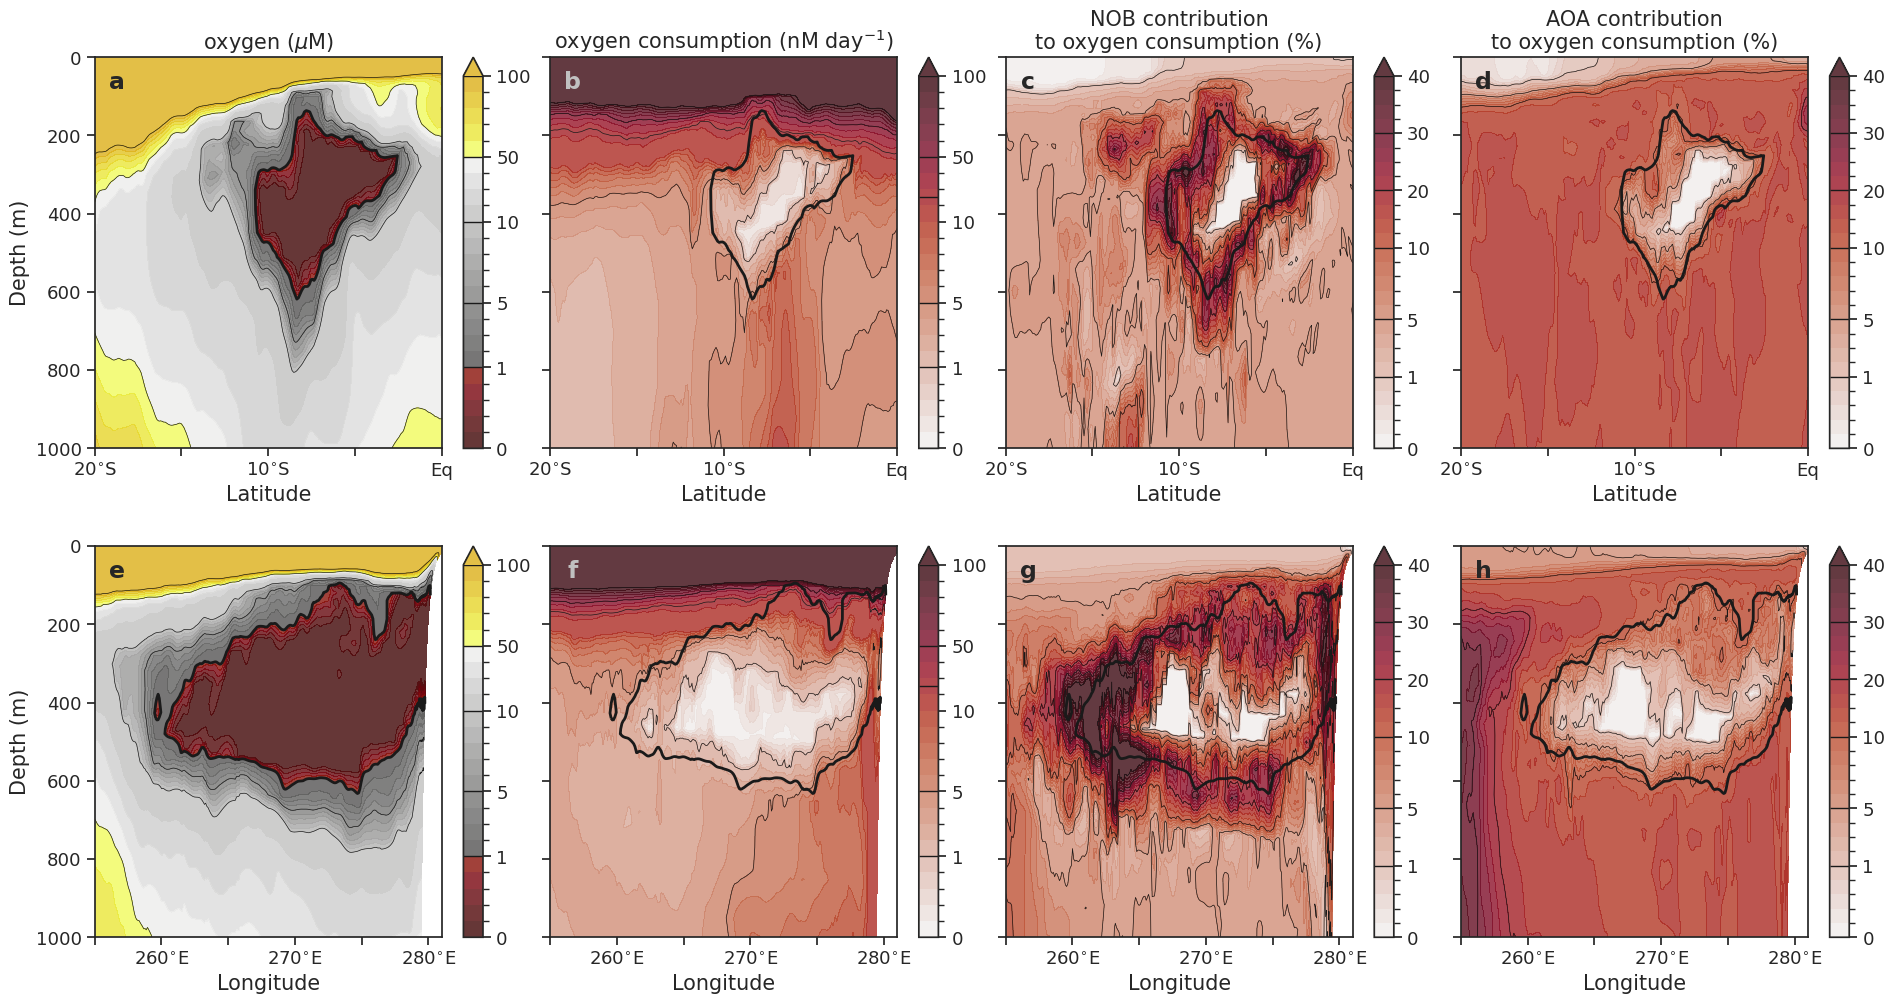

In [28]:

fig = plt.figure(facecolor='w', figsize=(20,11))
gs = GridSpec(2,4)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])

   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

norm_ytransect_o2nob = norm_ytransect_nox * (12.9/27.8) / norm_ytransect_o2cons * 100
norm_ytransect_o2aoa = norm_ytransect_nhx * (15.5/11.0) / norm_ytransect_o2cons * 100

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c4 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c4o2 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p5 = ax5.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c5 = ax5.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=conts1, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2cons.mean(dim='time').values[:,0:314]*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c6 = ax6.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2cons.mean(dim='time').values[:,0:314]*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

norm_xtransect_o2nob = norm_xtransect_nox * (12.9/27.8) / norm_xtransect_o2cons * 100
norm_xtransect_o2aoa = norm_xtransect_nhx * (15.5/11.0) / norm_xtransect_o2cons * 100

p7 = ax7.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2nob.mean(dim='time').values[:,0:314], \
                 vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c7 = ax7.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2nob.mean(dim='time').values[:,0:314], \
                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2aoa.mean(dim='time').values[:,0:314], \
                 vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c8 = ax8.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2aoa.mean(dim='time').values[:,0:314], \
                 levels=conts3, colors=contcol, linewidths=contl3)
c8o2 = ax8.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,9,14,18,23]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs2[[0,5,9,14,18,23]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs3[[0,5,9,14,18,22,-1]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs3[[0,5,9,14,18,22,-1]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs1[[0,5,9,14,18,23]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,14,18,23]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs3[[0,5,9,14,18,22,-1]])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs3[[0,5,9,14,18,22,-1]])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)


x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
x1 = 255; x2 = 281
y1 = -1000; y2 = 0
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)


ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax4.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.075, right=0.975, wspace=0.05, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax4.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])
ax6.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])
ax7.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])
ax8.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Longitude", fontsize=fslab)
ax6.set_xlabel("Longitude", fontsize=fslab)
ax7.set_xlabel("Longitude", fontsize=fslab)
ax8.set_xlabel("Longitude", fontsize=fslab)

ax1.set_title("oxygen ($\mu$M)", fontsize=fslab)
ax2.set_title("oxygen consumption (nM day$^{-1}$)", fontsize=fslab)
ax3.set_title("NOB contribution\nto oxygen consumption (%)", fontsize=fslab)
ax4.set_title("AOA contribution\nto oxygen consumption (%)", fontsize=fslab)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)

cb1.ax.hlines(conts1, 0,1, color='k', linewidth=1.0)
cb2.ax.hlines(conts2, 0,1, color='k', linewidth=1.0)
cb3.ax.hlines(conts3, 0,1, color='k', linewidth=1.0)
cb4.ax.hlines(conts3, 0,1, color='k', linewidth=1.0)
cb5.ax.hlines(conts1, 0,1, color='k', linewidth=1.0)
cb6.ax.hlines(conts2, 0,1, color='k', linewidth=1.0)
cb7.ax.hlines(conts3, 0,1, color='k', linewidth=1.0)
cb8.ax.hlines(conts3, 0,1, color='k', linewidth=1.0)


In [29]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig9.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig9.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig9_transparent.png", dpi=300, transparent=True)



## make other supp figure of O2 consumption for the different sensitivity experiments

In [13]:

contcol = 'k' 

fstic = 13
fslab = 15

colmap1 = lighten(cmo.oxy, 0.8)
levs1 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [1, 5, 10, 50, 100]
contl1 = [0.5, 0.5, 0.5, 0.5, 0.5]

colmap2 = lighten(cmo.amp, 0.8)
levs2 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm2 = mpl.colors.BoundaryNorm(levs2, colmap2.N)
conts2 = [1, 5, 25, 50, 100]
contl2 = [0.5, 0.5, 0.5, 0.5, 0.5]

colmap3 = lighten(cmo.amp, 0.8)
levs3 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,41,2.5)))
norm3 = mpl.colors.BoundaryNorm(levs3, colmap3.N)
conts3 = [1, 5, 10, 20, 30, 40]
contl3 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

colmap1dif = lighten(cmo.balance, 0.8)
levs1dif = np.arange(-10,11,1)
levs1dif = np.concatenate(( np.arange(-100,-10,10), np.arange(-10,10,), np.arange(10,101,10) ))*0.1
norm1dif = mpl.colors.BoundaryNorm(levs1dif, colmap1dif.N)

colmap2dif = lighten(cmo.balance, 0.8)
levs2dif = np.arange(-50,51,5)
norm2dif = mpl.colors.BoundaryNorm(levs2dif, colmap2dif.N)

colmap3dif = lighten(cmo.balance, 0.8)
levs3dif = np.arange(-10,11,1)
norm3dif = mpl.colors.BoundaryNorm(levs3dif, colmap3dif.N)



### change figure 

Text(-0.5, 0.5, '$\\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\\circ}$C\n$\\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\\circ}$C\n$\\mu^{max}_{AOA}$ = 2.0 day$^{-1}$ at 30$^{\\circ}$C')

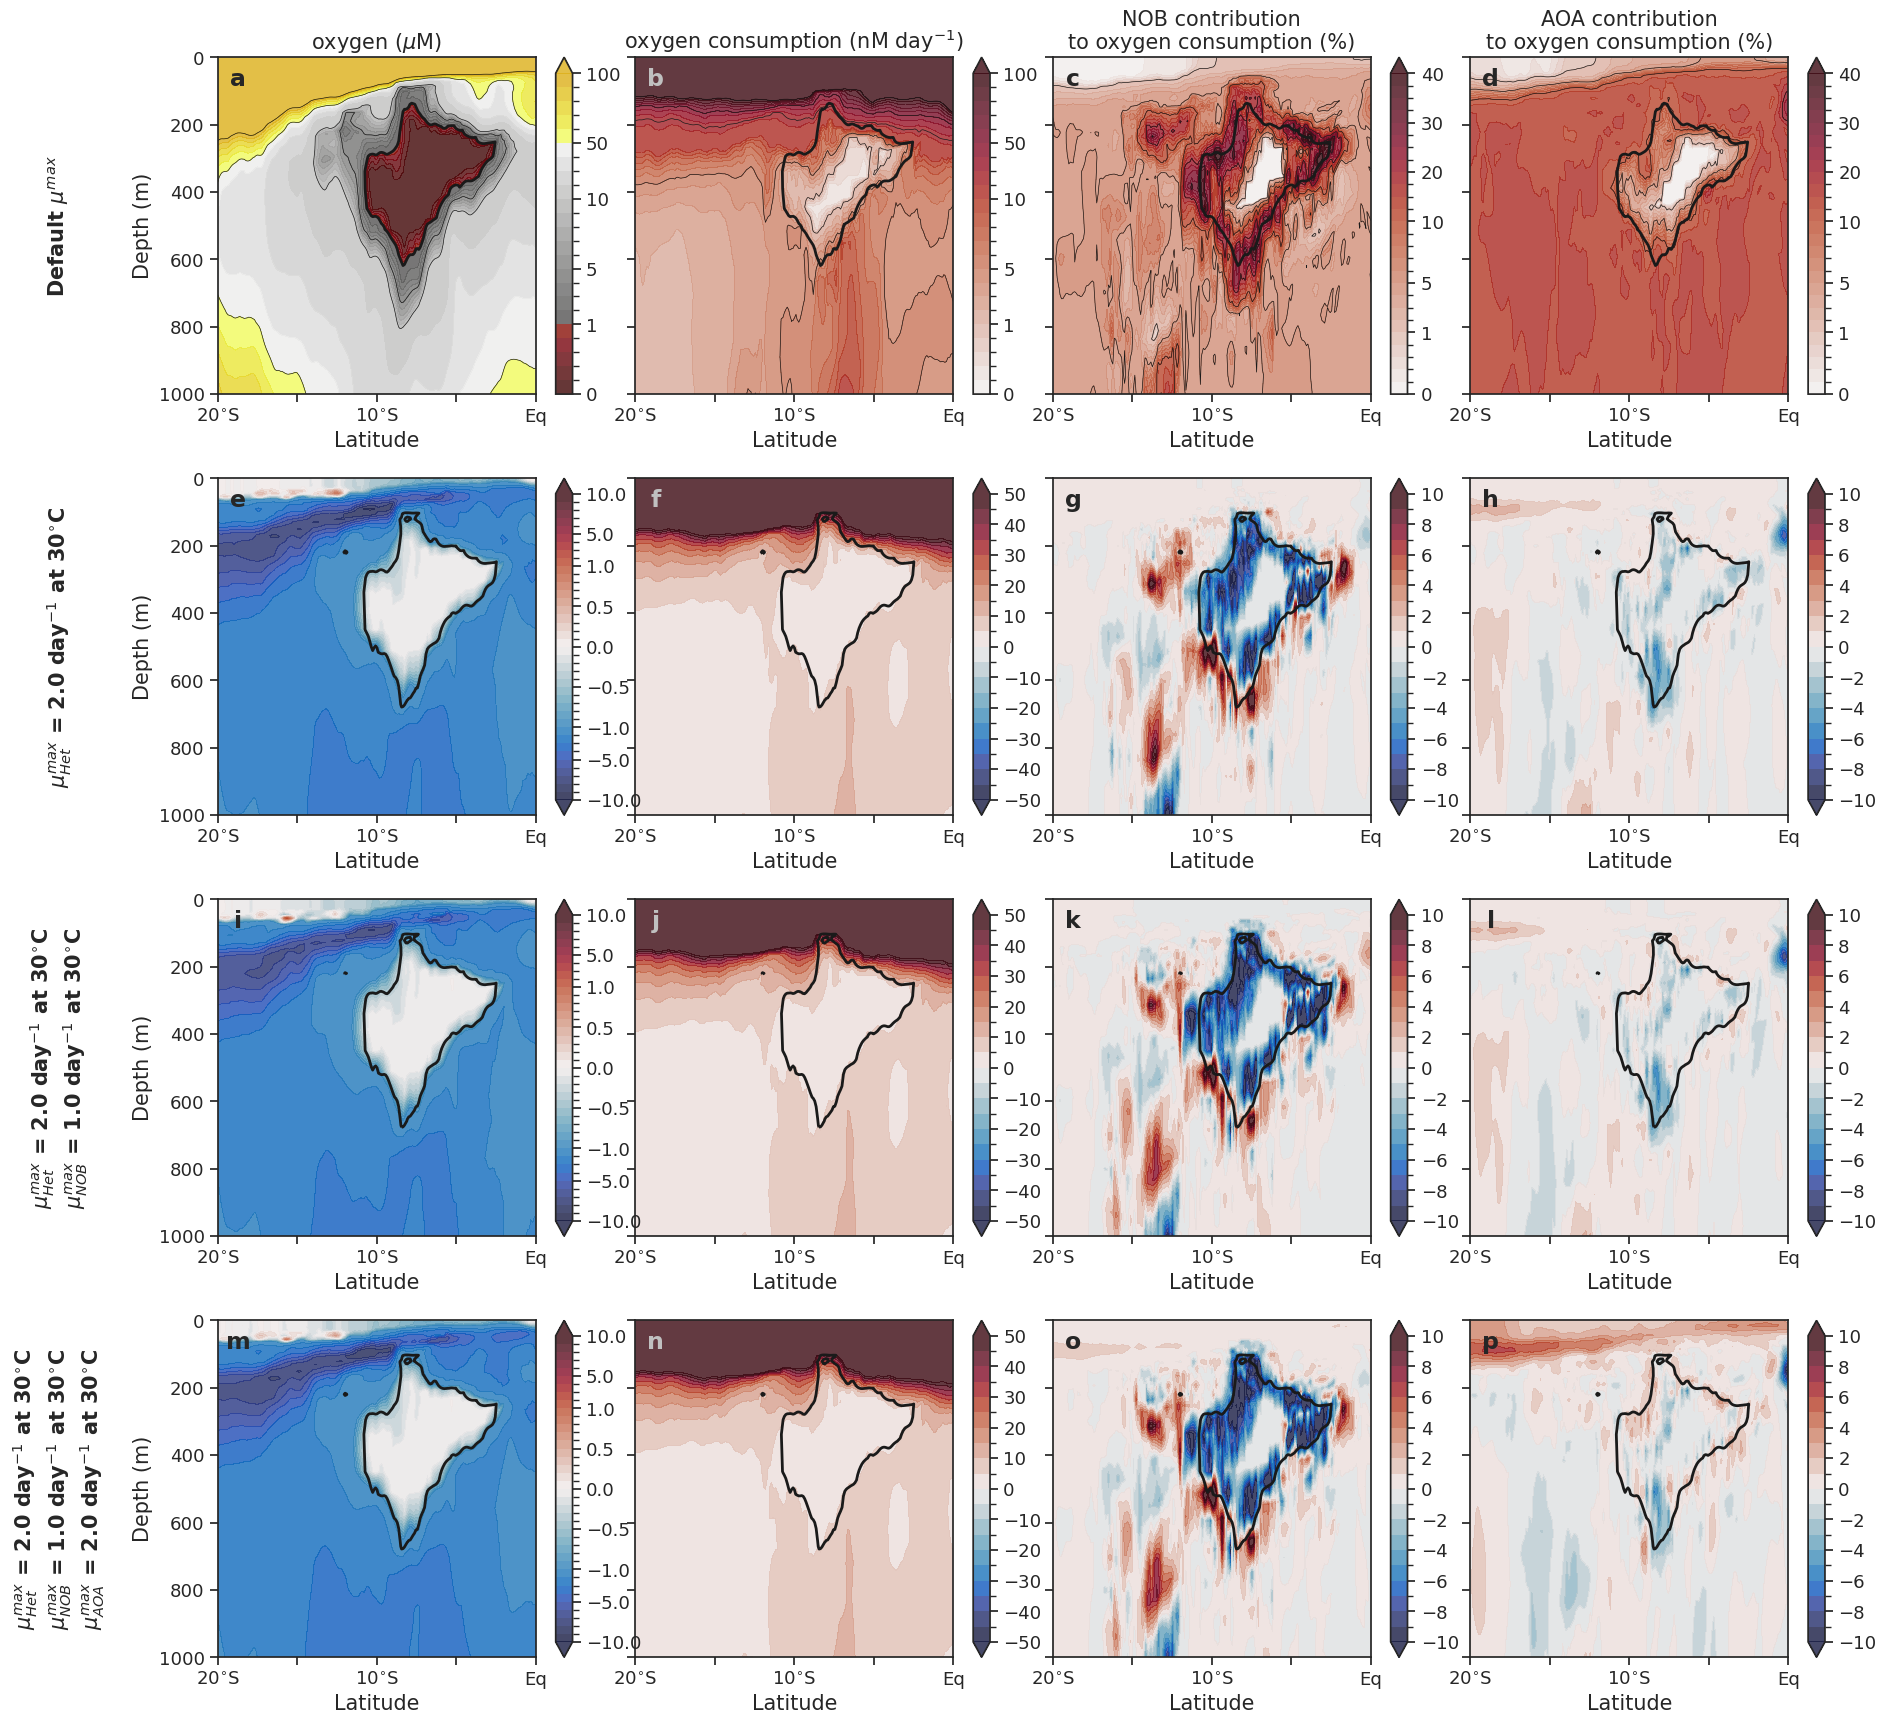

In [63]:
fig = plt.figure(facecolor='w', figsize=(20,20))
gs = GridSpec(4,4)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax12 = plt.subplot(gs[2,3])
ax13 = plt.subplot(gs[3,0])
ax14 = plt.subplot(gs[3,1])
ax15 = plt.subplot(gs[3,2])
ax16 = plt.subplot(gs[3,3])


   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

norm_ytransect_o2nob = norm_ytransect_nox * (12.9/27.8) / norm_ytransect_o2cons * 100
norm_ytransect_o2aoa = norm_ytransect_nhx * (15.5/11.0) / norm_ytransect_o2cons * 100

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c4 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c4o2 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p5 = ax5.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_o2.mean(dim='time')-norm_ytransect_o2.mean(dim='time')), \
                  vmin=levs1dif[0], vmax=levs1dif[-1], cmap=colmap1dif, norm=norm1dif, levels=levs1dif, extend='both')
#c5 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_o2.mean(dim='time')-norm_ytransect_o2.mean(dim='time')), \
#                 levels=conts1dif, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2dif[0], vmax=levs2dif[-1], cmap=colmap2dif, norm=norm2dif, levels=levs2dif, extend='both')
#c6 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

het2_ytransect_o2nob = het2_ytransect_nox * (12.9/27.8) / het2_ytransect_o2cons * 100
het2_ytransect_o2aoa = het2_ytransect_nhx * (15.5/11.0) / het2_ytransect_o2cons * 100

p7 = ax7.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_o2nob.mean(dim='time')-norm_ytransect_o2nob.mean(dim='time')), \
                  vmin=levs3dif[0], vmax=levs3dif[-1], cmap=colmap3dif, norm=norm3dif, levels=levs3dif, extend='both')
#c7 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_o2aoa.mean(dim='time')-norm_ytransect_o2aoa.mean(dim='time')), \
                  vmin=levs3dif[0], vmax=levs3dif[-1], cmap=colmap3dif, norm=norm3dif, levels=levs3dif, extend='both')
#c8 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c8o2 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p9 = ax9.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_o2.mean(dim='time')-norm_ytransect_o2.mean(dim='time')), \
                  vmin=levs1dif[0], vmax=levs1dif[-1], cmap=colmap1dif, norm=norm1dif, levels=levs1dif, extend='both')
#c9 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_o2.mean(dim='time')-norm_ytransect_o2.mean(dim='time')), \
#                 levels=conts1dif, colors=contcol, linewidths=contl1)
c9o2 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p10 = ax10.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2dif[0], vmax=levs2dif[-1], cmap=colmap2dif, norm=norm2dif, levels=levs2dif, extend='both')
#c10 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c10o2 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

nob1_ytransect_o2nob = nob1_ytransect_nox * (12.9/27.8) / nob1_ytransect_o2cons * 100
nob1_ytransect_o2aoa = nob1_ytransect_nhx * (15.5/11.0) / nob1_ytransect_o2cons * 100

p11 = ax11.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_o2nob.mean(dim='time')-norm_ytransect_o2nob.mean(dim='time')), \
                  vmin=levs3dif[0], vmax=levs3dif[-1], cmap=colmap3dif, norm=norm3dif, levels=levs3dif, extend='both')
#c11 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c11o2 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p12 = ax12.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_o2aoa.mean(dim='time')-norm_ytransect_o2aoa.mean(dim='time')), \
                  vmin=levs3dif[0], vmax=levs3dif[-1], cmap=colmap3dif, norm=norm3dif, levels=levs3dif, extend='both')
#c12 = ax12.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c12o2 = ax12.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p13 = ax13.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, (all_ytransect_o2.mean(dim='time')-norm_ytransect_o2.mean(dim='time')), \
                  vmin=levs1dif[0], vmax=levs1dif[-1], cmap=colmap1dif, norm=norm1dif, levels=levs1dif, extend='both')
#c13 = ax13.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, (all_ytransect_o2.mean(dim='time')-norm_ytransect_o2.mean(dim='time')), \
#                 levels=conts1dif, colors=contcol, linewidths=contl1)
c13o2 = ax13.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p14 = ax14.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2dif[0], vmax=levs2dif[-1], cmap=colmap2dif, norm=norm2dif, levels=levs2dif, extend='both')
#c14 = ax14.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c14o2 = ax14.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

all_ytransect_o2nob = all_ytransect_nox * (12.9/27.8) / all_ytransect_o2cons * 100
all_ytransect_o2aoa = all_ytransect_nhx * (15.5/11.0) / all_ytransect_o2cons * 100

p15 = ax15.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, (all_ytransect_o2nob.mean(dim='time')-norm_ytransect_o2nob.mean(dim='time')), \
                  vmin=levs3dif[0], vmax=levs3dif[-1], cmap=colmap3dif, norm=norm3dif, levels=levs3dif, extend='both')
#c15 = ax15.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c15o2 = ax15.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p16 = ax16.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, (all_ytransect_o2aoa.mean(dim='time')-norm_ytransect_o2aoa.mean(dim='time')), \
                  vmin=levs3dif[0], vmax=levs3dif[-1], cmap=colmap3dif, norm=norm3dif, levels=levs3dif, extend='both')
#c16 = ax16.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c16o2 = ax16.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,9,14,18,23]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs2[[0,5,9,14,18,23]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs3[[0,5,9,14,18,22,-1]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs3[[0,5,9,14,18,22,-1]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs1dif[[0,5,9,14,19,24,29,33,38]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2dif[::2])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs3dif[::2])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs3dif[::2])
cb9 = plt.colorbar(p9, ax=ax9, ticks=levs1dif[[0,5,9,14,19,24,29,33,38]])
cb10 = plt.colorbar(p10, ax=ax10, ticks=levs2dif[::2])
cb11 = plt.colorbar(p11, ax=ax11, ticks=levs3dif[::2])
cb12 = plt.colorbar(p12, ax=ax12, ticks=levs3dif[::2])
cb13 = plt.colorbar(p13, ax=ax13, ticks=levs1dif[[0,5,9,14,19,24,29,33,38]])
cb14 = plt.colorbar(p14, ax=ax14, ticks=levs2dif[::2])
cb15 = plt.colorbar(p15, ax=ax15, ticks=levs3dif[::2])
cb16 = plt.colorbar(p16, ax=ax16, ticks=levs3dif[::2])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)
cb9.ax.tick_params(labelsize=fstic)
cb10.ax.tick_params(labelsize=fstic)
cb11.ax.tick_params(labelsize=fstic)
cb12.ax.tick_params(labelsize=fstic)
cb13.ax.tick_params(labelsize=fstic)
cb14.ax.tick_params(labelsize=fstic)
cb15.ax.tick_params(labelsize=fstic)
cb16.ax.tick_params(labelsize=fstic)


x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)
ax9.set_xlim(x1,x2)
ax9.set_ylim(y1,y2)
ax10.set_xlim(x1,x2)
ax10.set_ylim(y1,y2)
ax11.set_xlim(x1,x2)
ax11.set_ylim(y1,y2)
ax12.set_xlim(x1,x2)
ax12.set_ylim(y1,y2)
ax13.set_xlim(x1,x2)
ax13.set_ylim(y1,y2)
ax14.set_xlim(x1,x2)
ax14.set_ylim(y1,y2)
ax15.set_xlim(x1,x2)
ax15.set_ylim(y1,y2)
ax16.set_xlim(x1,x2)
ax16.set_ylim(y1,y2)



ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax4.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)
ax9.tick_params(labelsize=fstic)
ax10.tick_params(labelsize=fstic, labelleft=False)
ax11.tick_params(labelsize=fstic, labelleft=False)
ax12.tick_params(labelsize=fstic, labelleft=False)
ax13.tick_params(labelsize=fstic)
ax14.tick_params(labelsize=fstic, labelleft=False)
ax15.tick_params(labelsize=fstic, labelleft=False)
ax16.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.15, right=0.975, wspace=0.05, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax4.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax6.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax7.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax8.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax9.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax9.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax10.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax11.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax12.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax13.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax13.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax14.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax15.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax16.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])


ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Latitude", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax8.set_xlabel("Latitude", fontsize=fslab)
ax9.set_ylabel("Depth (m)", fontsize=fslab)
ax9.set_xlabel("Latitude", fontsize=fslab)
ax10.set_xlabel("Latitude", fontsize=fslab)
ax11.set_xlabel("Latitude", fontsize=fslab)
ax12.set_xlabel("Latitude", fontsize=fslab)
ax13.set_ylabel("Depth (m)", fontsize=fslab)
ax13.set_xlabel("Latitude", fontsize=fslab)
ax14.set_xlabel("Latitude", fontsize=fslab)
ax15.set_xlabel("Latitude", fontsize=fslab)
ax16.set_xlabel("Latitude", fontsize=fslab)


ax1.set_title("oxygen ($\mu$M)", fontsize=fslab)
ax2.set_title("oxygen consumption (nM day$^{-1}$)", fontsize=fslab)
ax3.set_title("NOB contribution\nto oxygen consumption (%)", fontsize=fslab)
ax4.set_title("AOA contribution\nto oxygen consumption (%)", fontsize=fslab)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes, color='silver')
plt.text(xx,yy,'k', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax11.transAxes)
plt.text(xx,yy,'l', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax12.transAxes)
plt.text(xx,yy,'m', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax13.transAxes)
plt.text(xx,yy,'n', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax14.transAxes, color='silver')
plt.text(xx,yy,'o', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax15.transAxes)
plt.text(xx,yy,'p', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax16.transAxes)


xx = -0.5; yy = 0.5
plt.text(xx,yy,'Default $\mu^{max}$', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax1.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax5.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax9.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{AOA}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax13.transAxes)


In [64]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig11_change.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig11_change.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig11_change_transparent.png", dpi=300, transparent=True)


### absolute values figure

Text(-0.5, 0.5, '$\\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\\circ}$C\n$\\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\\circ}$C\n$\\mu^{max}_{AOA}$ = 2.0 day$^{-1}$ at 30$^{\\circ}$C')

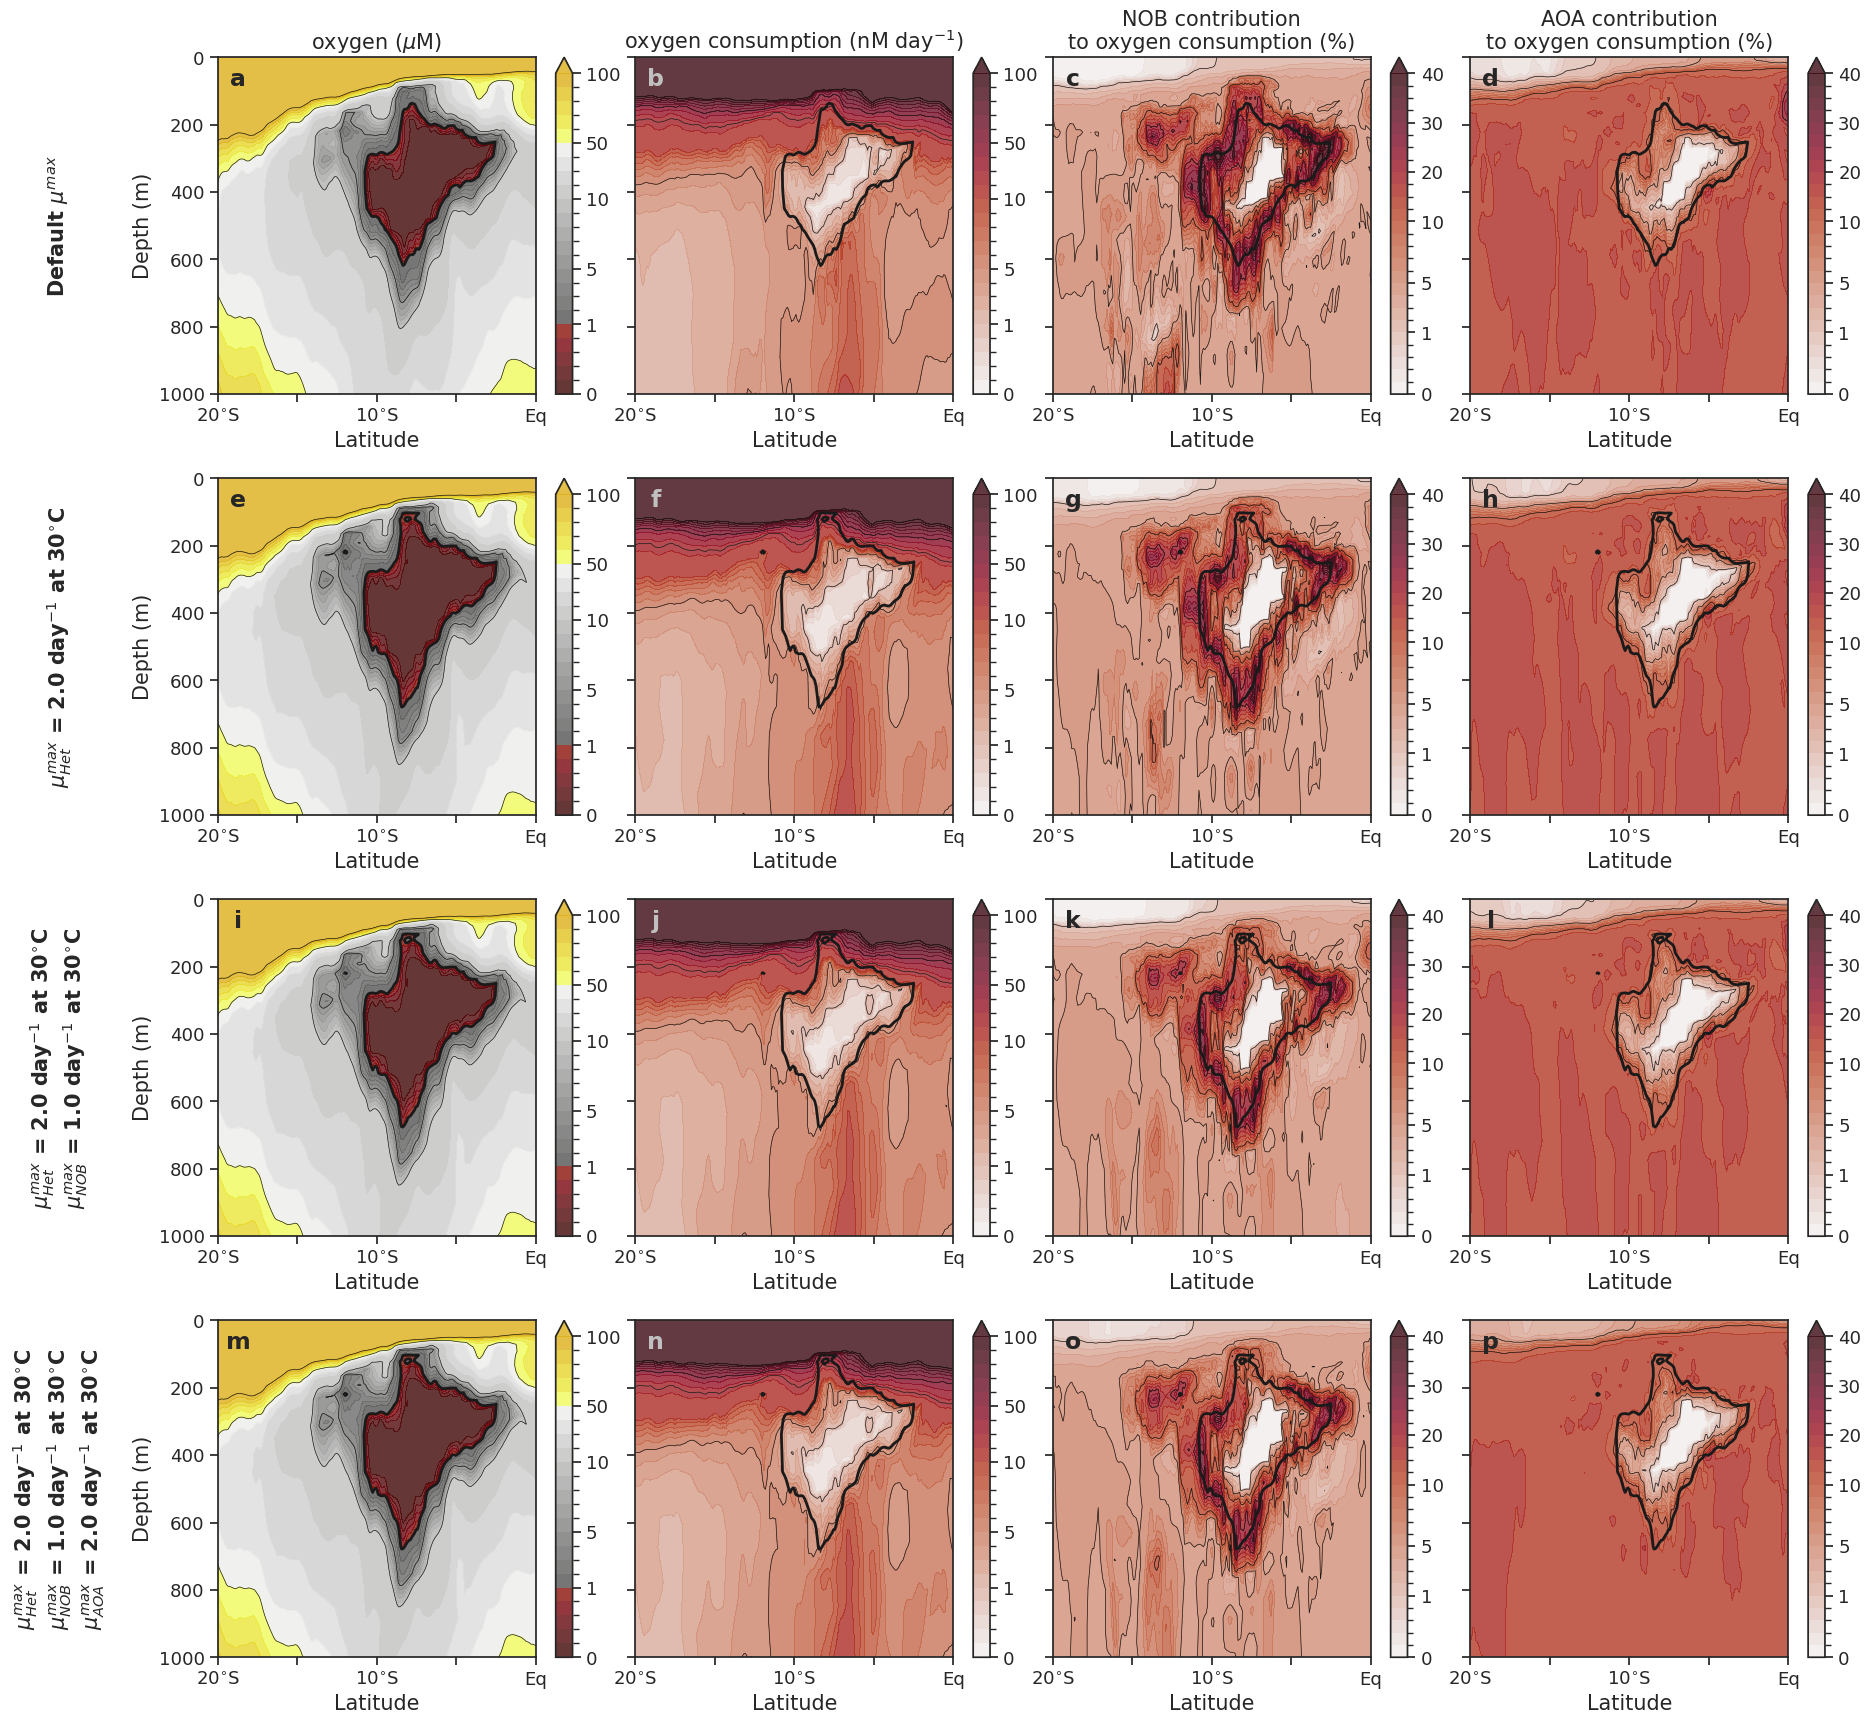

In [14]:
fig = plt.figure(facecolor='w', figsize=(20,20))
gs = GridSpec(4,4)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax12 = plt.subplot(gs[2,3])
ax13 = plt.subplot(gs[3,0])
ax14 = plt.subplot(gs[3,1])
ax15 = plt.subplot(gs[3,2])
ax16 = plt.subplot(gs[3,3])


   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

norm_ytransect_o2nob = norm_ytransect_nox * (12.9/27.8) / norm_ytransect_o2cons * 100
norm_ytransect_o2aoa = norm_ytransect_nhx * (15.5/11.0) / norm_ytransect_o2cons * 100

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c4 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c4o2 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p5 = ax5.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c5 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c6 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

het2_ytransect_o2nob = het2_ytransect_nox * (12.9/27.8) / het2_ytransect_o2cons * 100
het2_ytransect_o2aoa = het2_ytransect_nhx * (15.5/11.0) / het2_ytransect_o2cons * 100

p7 = ax7.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c7 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c8 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c8o2 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p9 = ax9.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c9 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c9o2 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p10 = ax10.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c10 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c10o2 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

nob1_ytransect_o2nob = nob1_ytransect_nox * (12.9/27.8) / nob1_ytransect_o2cons * 100
nob1_ytransect_o2aoa = nob1_ytransect_nhx * (15.5/11.0) / nob1_ytransect_o2cons * 100

p11 = ax11.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
                vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c11 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c11o2 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p12 = ax12.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c12 = ax12.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c12o2 = ax12.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p13 = ax13.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c13 = ax13.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c13o2 = ax13.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p14 = ax14.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c14 = ax14.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c14o2 = ax14.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

all_ytransect_o2nob = all_ytransect_nox * (12.9/27.8) / all_ytransect_o2cons * 100
all_ytransect_o2aoa = all_ytransect_nhx * (15.5/11.0) / all_ytransect_o2cons * 100

p15 = ax15.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2nob.mean(dim='time'), \
                vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c15 = ax15.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c15o2 = ax15.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p16 = ax16.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c16 = ax16.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c16o2 = ax16.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,9,14,18,23]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs2[[0,5,9,14,18,23]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs3[[0,5,9,14,18,22,-1]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs3[[0,5,9,14,18,22,-1]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs1[[0,5,9,14,18,23]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,14,18,23]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs3[[0,5,9,14,18,22,-1]])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs3[[0,5,9,14,18,22,-1]])
cb9 = plt.colorbar(p9, ax=ax9, ticks=levs1[[0,5,9,14,18,23]])
cb10 = plt.colorbar(p10, ax=ax10, ticks=levs2[[0,5,9,14,18,23]])
cb11 = plt.colorbar(p11, ax=ax11, ticks=levs3[[0,5,9,14,18,22,-1]])
cb12 = plt.colorbar(p12, ax=ax12, ticks=levs3[[0,5,9,14,18,22,-1]])
cb13 = plt.colorbar(p13, ax=ax13, ticks=levs1[[0,5,9,14,18,23]])
cb14 = plt.colorbar(p14, ax=ax14, ticks=levs2[[0,5,9,14,18,23]])
cb15 = plt.colorbar(p15, ax=ax15, ticks=levs3[[0,5,9,14,18,22,-1]])
cb16 = plt.colorbar(p16, ax=ax16, ticks=levs3[[0,5,9,14,18,22,-1]])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)
cb9.ax.tick_params(labelsize=fstic)
cb10.ax.tick_params(labelsize=fstic)
cb11.ax.tick_params(labelsize=fstic)
cb12.ax.tick_params(labelsize=fstic)
cb13.ax.tick_params(labelsize=fstic)
cb14.ax.tick_params(labelsize=fstic)
cb15.ax.tick_params(labelsize=fstic)
cb16.ax.tick_params(labelsize=fstic)

x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)
ax9.set_xlim(x1,x2)
ax9.set_ylim(y1,y2)
ax10.set_xlim(x1,x2)
ax10.set_ylim(y1,y2)
ax11.set_xlim(x1,x2)
ax11.set_ylim(y1,y2)
ax12.set_xlim(x1,x2)
ax12.set_ylim(y1,y2)
ax13.set_xlim(x1,x2)
ax13.set_ylim(y1,y2)
ax14.set_xlim(x1,x2)
ax14.set_ylim(y1,y2)
ax15.set_xlim(x1,x2)
ax15.set_ylim(y1,y2)
ax16.set_xlim(x1,x2)
ax16.set_ylim(y1,y2)


ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax4.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)
ax9.tick_params(labelsize=fstic)
ax10.tick_params(labelsize=fstic, labelleft=False)
ax11.tick_params(labelsize=fstic, labelleft=False)
ax12.tick_params(labelsize=fstic, labelleft=False)
ax13.tick_params(labelsize=fstic)
ax14.tick_params(labelsize=fstic, labelleft=False)
ax15.tick_params(labelsize=fstic, labelleft=False)
ax16.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.15, right=0.975, wspace=0.05, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax4.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax6.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax7.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax8.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax9.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax9.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax10.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax11.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax12.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax13.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax13.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax14.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax15.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax16.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])


ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Latitude", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax8.set_xlabel("Latitude", fontsize=fslab)
ax9.set_ylabel("Depth (m)", fontsize=fslab)
ax9.set_xlabel("Latitude", fontsize=fslab)
ax10.set_xlabel("Latitude", fontsize=fslab)
ax11.set_xlabel("Latitude", fontsize=fslab)
ax12.set_xlabel("Latitude", fontsize=fslab)
ax13.set_ylabel("Depth (m)", fontsize=fslab)
ax13.set_xlabel("Latitude", fontsize=fslab)
ax14.set_xlabel("Latitude", fontsize=fslab)
ax15.set_xlabel("Latitude", fontsize=fslab)
ax16.set_xlabel("Latitude", fontsize=fslab)


ax1.set_title("oxygen ($\mu$M)", fontsize=fslab)
ax2.set_title("oxygen consumption (nM day$^{-1}$)", fontsize=fslab)
ax3.set_title("NOB contribution\nto oxygen consumption (%)", fontsize=fslab)
ax4.set_title("AOA contribution\nto oxygen consumption (%)", fontsize=fslab)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes, color='silver')
plt.text(xx,yy,'k', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax11.transAxes)
plt.text(xx,yy,'l', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax12.transAxes)
plt.text(xx,yy,'m', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax13.transAxes)
plt.text(xx,yy,'n', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax14.transAxes, color='silver')
plt.text(xx,yy,'o', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax15.transAxes)
plt.text(xx,yy,'p', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax16.transAxes)


xx = -0.5; yy = 0.5
plt.text(xx,yy,'Default $\mu^{max}$', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax1.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax5.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax9.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{AOA}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax13.transAxes)


In [15]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig11_absolute.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig11_absolute.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig11_absolute_transparent.png", dpi=300, transparent=True)


### this one with Het=2, Het&AOA=2, and NOB=1

Text(-0.5, 0.5, '$\\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$\n$\\mu^{max}_{AOA}$ = 2.0 day$^{-1}$\n$\\mu^{max}_{NOB}$ = 1.0 day$^{-1}$')

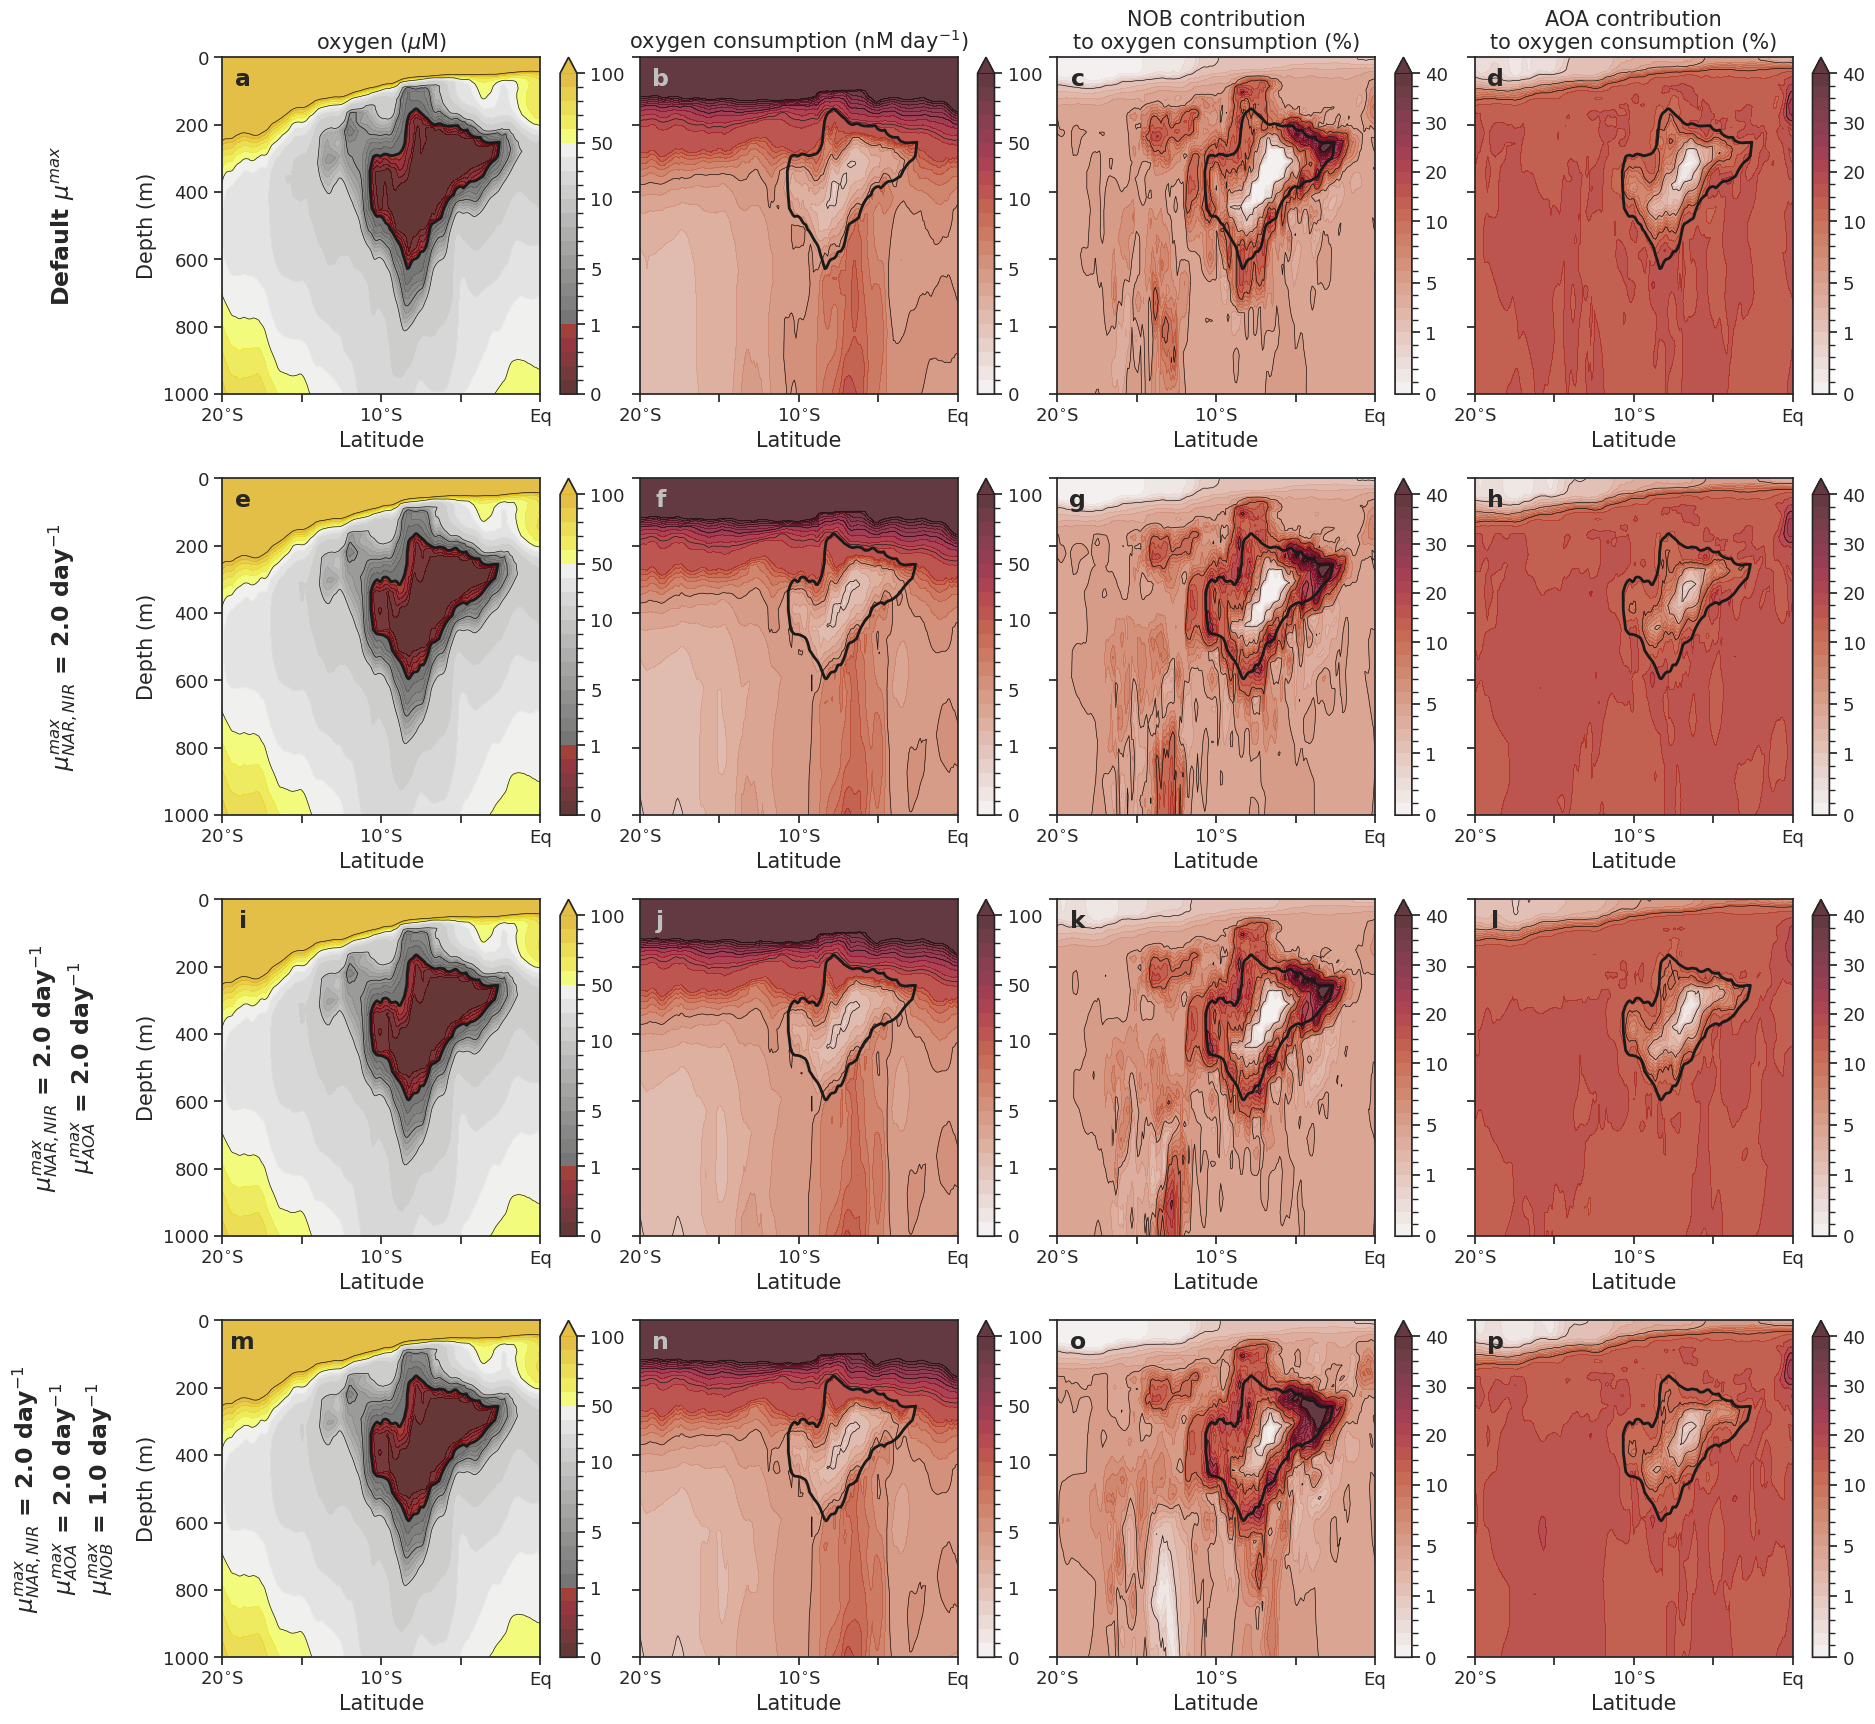

In [44]:

fig = plt.figure(facecolor='w', figsize=(20,20))
gs = GridSpec(4,4)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax12 = plt.subplot(gs[2,3])
ax13 = plt.subplot(gs[3,0])
ax14 = plt.subplot(gs[3,1])
ax15 = plt.subplot(gs[3,2])
ax16 = plt.subplot(gs[3,3])

   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

norm_ytransect_o2nob = norm_ytransect_nox * (12.9/27.8) / norm_ytransect_o2cons * 100
norm_ytransect_o2aoa = norm_ytransect_nhx * (15.5/11.0) / norm_ytransect_o2cons * 100

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c4 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c4o2 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p5 = ax5.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c5 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c6 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

het2_ytransect_o2nob = het2_ytransect_nox * (12.9/27.8) / het2_ytransect_o2cons * 100
het2_ytransect_o2aoa = het2_ytransect_nhx * (15.5/11.0) / het2_ytransect_o2cons * 100

p7 = ax7.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c7 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c8 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c8o2 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p9 = ax9.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c9 = ax9.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c9o2 = ax9.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p10 = ax10.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c10 = ax10.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c10o2 = ax10.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

both_ytransect_o2nob = both_ytransect_nox * (12.9/27.8) / both_ytransect_o2cons * 100
both_ytransect_o2aoa = both_ytransect_nhx * (15.5/11.0) / both_ytransect_o2cons * 100

p11 = ax11.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c11 = ax11.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c11o2 = ax11.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p12 = ax12.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c12 = ax12.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c12o2 = ax12.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p13 = ax13.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c13 = ax13.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c13o2 = ax13.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p14 = ax14.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c14 = ax14.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c14o2 = ax14.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

nob1_ytransect_o2nob = nob1_ytransect_nox * (12.9/27.8) / nob1_ytransect_o2cons * 100
nob1_ytransect_o2aoa = nob1_ytransect_nhx * (15.5/11.0) / nob1_ytransect_o2cons * 100

p15 = ax15.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c15 = ax15.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c15o2 = ax15.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p16 = ax16.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c16 = ax16.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c16o2 = ax16.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,9,14,18,23]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs2[[0,5,9,14,18,23]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs3[[0,5,9,14,18,22,-1]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs3[[0,5,9,14,18,22,-1]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs1[[0,5,9,14,18,23]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,14,18,23]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs3[[0,5,9,14,18,22,-1]])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs3[[0,5,9,14,18,22,-1]])
cb9 = plt.colorbar(p9, ax=ax9, ticks=levs1[[0,5,9,14,18,23]])
cb10 = plt.colorbar(p10, ax=ax10, ticks=levs2[[0,5,9,14,18,23]])
cb11 = plt.colorbar(p11, ax=ax11, ticks=levs3[[0,5,9,14,18,22,-1]])
cb12 = plt.colorbar(p12, ax=ax12, ticks=levs3[[0,5,9,14,18,22,-1]])
cb13 = plt.colorbar(p13, ax=ax13, ticks=levs1[[0,5,9,14,18,23]])
cb14 = plt.colorbar(p14, ax=ax14, ticks=levs2[[0,5,9,14,18,23]])
cb15 = plt.colorbar(p15, ax=ax15, ticks=levs3[[0,5,9,14,18,22,-1]])
cb16 = plt.colorbar(p16, ax=ax16, ticks=levs3[[0,5,9,14,18,22,-1]])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)
cb9.ax.tick_params(labelsize=fstic)
cb10.ax.tick_params(labelsize=fstic)
cb11.ax.tick_params(labelsize=fstic)
cb12.ax.tick_params(labelsize=fstic)
cb13.ax.tick_params(labelsize=fstic)
cb14.ax.tick_params(labelsize=fstic)
cb15.ax.tick_params(labelsize=fstic)
cb16.ax.tick_params(labelsize=fstic)


x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)
ax9.set_xlim(x1,x2)
ax9.set_ylim(y1,y2)
ax10.set_xlim(x1,x2)
ax10.set_ylim(y1,y2)
ax11.set_xlim(x1,x2)
ax11.set_ylim(y1,y2)
ax12.set_xlim(x1,x2)
ax12.set_ylim(y1,y2)
ax13.set_xlim(x1,x2)
ax13.set_ylim(y1,y2)
ax14.set_xlim(x1,x2)
ax14.set_ylim(y1,y2)
ax15.set_xlim(x1,x2)
ax15.set_ylim(y1,y2)
ax16.set_xlim(x1,x2)
ax16.set_ylim(y1,y2)


ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax4.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)
ax9.tick_params(labelsize=fstic)
ax10.tick_params(labelsize=fstic, labelleft=False)
ax11.tick_params(labelsize=fstic, labelleft=False)
ax12.tick_params(labelsize=fstic, labelleft=False)
ax13.tick_params(labelsize=fstic)
ax14.tick_params(labelsize=fstic, labelleft=False)
ax15.tick_params(labelsize=fstic, labelleft=False)
ax16.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.15, right=0.975, wspace=0.05, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax4.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax6.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax7.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax8.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax9.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax9.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax10.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax11.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax12.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax13.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax13.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax14.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax15.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax16.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Latitude", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax8.set_xlabel("Latitude", fontsize=fslab)
ax9.set_ylabel("Depth (m)", fontsize=fslab)
ax9.set_xlabel("Latitude", fontsize=fslab)
ax10.set_xlabel("Latitude", fontsize=fslab)
ax11.set_xlabel("Latitude", fontsize=fslab)
ax12.set_xlabel("Latitude", fontsize=fslab)
ax13.set_ylabel("Depth (m)", fontsize=fslab)
ax13.set_xlabel("Latitude", fontsize=fslab)
ax14.set_xlabel("Latitude", fontsize=fslab)
ax15.set_xlabel("Latitude", fontsize=fslab)
ax16.set_xlabel("Latitude", fontsize=fslab)

ax1.set_title("oxygen ($\mu$M)", fontsize=fslab)
ax2.set_title("oxygen consumption (nM day$^{-1}$)", fontsize=fslab)
ax3.set_title("NOB contribution\nto oxygen consumption (%)", fontsize=fslab)
ax4.set_title("AOA contribution\nto oxygen consumption (%)", fontsize=fslab)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes, color='silver')
plt.text(xx,yy,'k', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax11.transAxes)
plt.text(xx,yy,'l', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax12.transAxes)
plt.text(xx,yy,'m', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax13.transAxes)
plt.text(xx,yy,'n', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax14.transAxes, color='silver')
plt.text(xx,yy,'o', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax15.transAxes)
plt.text(xx,yy,'p', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax16.transAxes)


xx = -0.5; yy = 0.5
plt.text(xx,yy,'Default $\mu^{max}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax1.transAxes)
plt.text(xx,yy,'$\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax5.transAxes)
plt.text(xx,yy,'$\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$\n$\mu^{max}_{AOA}$ = 2.0 day$^{-1}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax9.transAxes)
plt.text(xx,yy,'$\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$\n$\mu^{max}_{AOA}$ = 2.0 day$^{-1}$\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax13.transAxes)


In [45]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_sensitivity_exps.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_sensitivity_exps.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_sensitivity_exps_transparent.png", dpi=300, transparent=True)



## make another supp figure of the growth rates 

In [38]:

contcol = 'k' 

fstic = 13
fslab = 15

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,1,0.1),np.arange(1,10,1),np.arange(10,101,5)))*0.01
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
#conts1 = [1, 5, 10, 50, 100]
#contl1 = [0.5, 0.5, 0.5, 0.5, 0.5]

colmap2 = lighten(cmo.balance, 0.8)
levs2 = np.concatenate((np.arange(-10,-1,1),np.arange(-1,0,0.1),np.arange(0,1,0.1),np.arange(1,11,1)))*0.01
norm2 = mpl.colors.BoundaryNorm(levs2, colmap2.N)
#conts1 = [1, 5, 10, 50, 100]
#contl1 = [0.5, 0.5, 0.5, 0.5, 0.5]

norm_ytransect_hetmu = (norm_ytransect_narmu + norm_ytransect_niomu)*0.5
het2_ytransect_hetmu = (het2_ytransect_narmu + het2_ytransect_niomu)*0.5
nob1_ytransect_hetmu = (nob1_ytransect_narmu + nob1_ytransect_niomu)*0.5
all_ytransect_hetmu = (all_ytransect_narmu + all_ytransect_niomu)*0.5


### this one with only Het=2 and NOB=1 (with anammox)

Text(-0.5, 0.5, '$\\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\\circ}$C\n$\\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\\circ}$C')

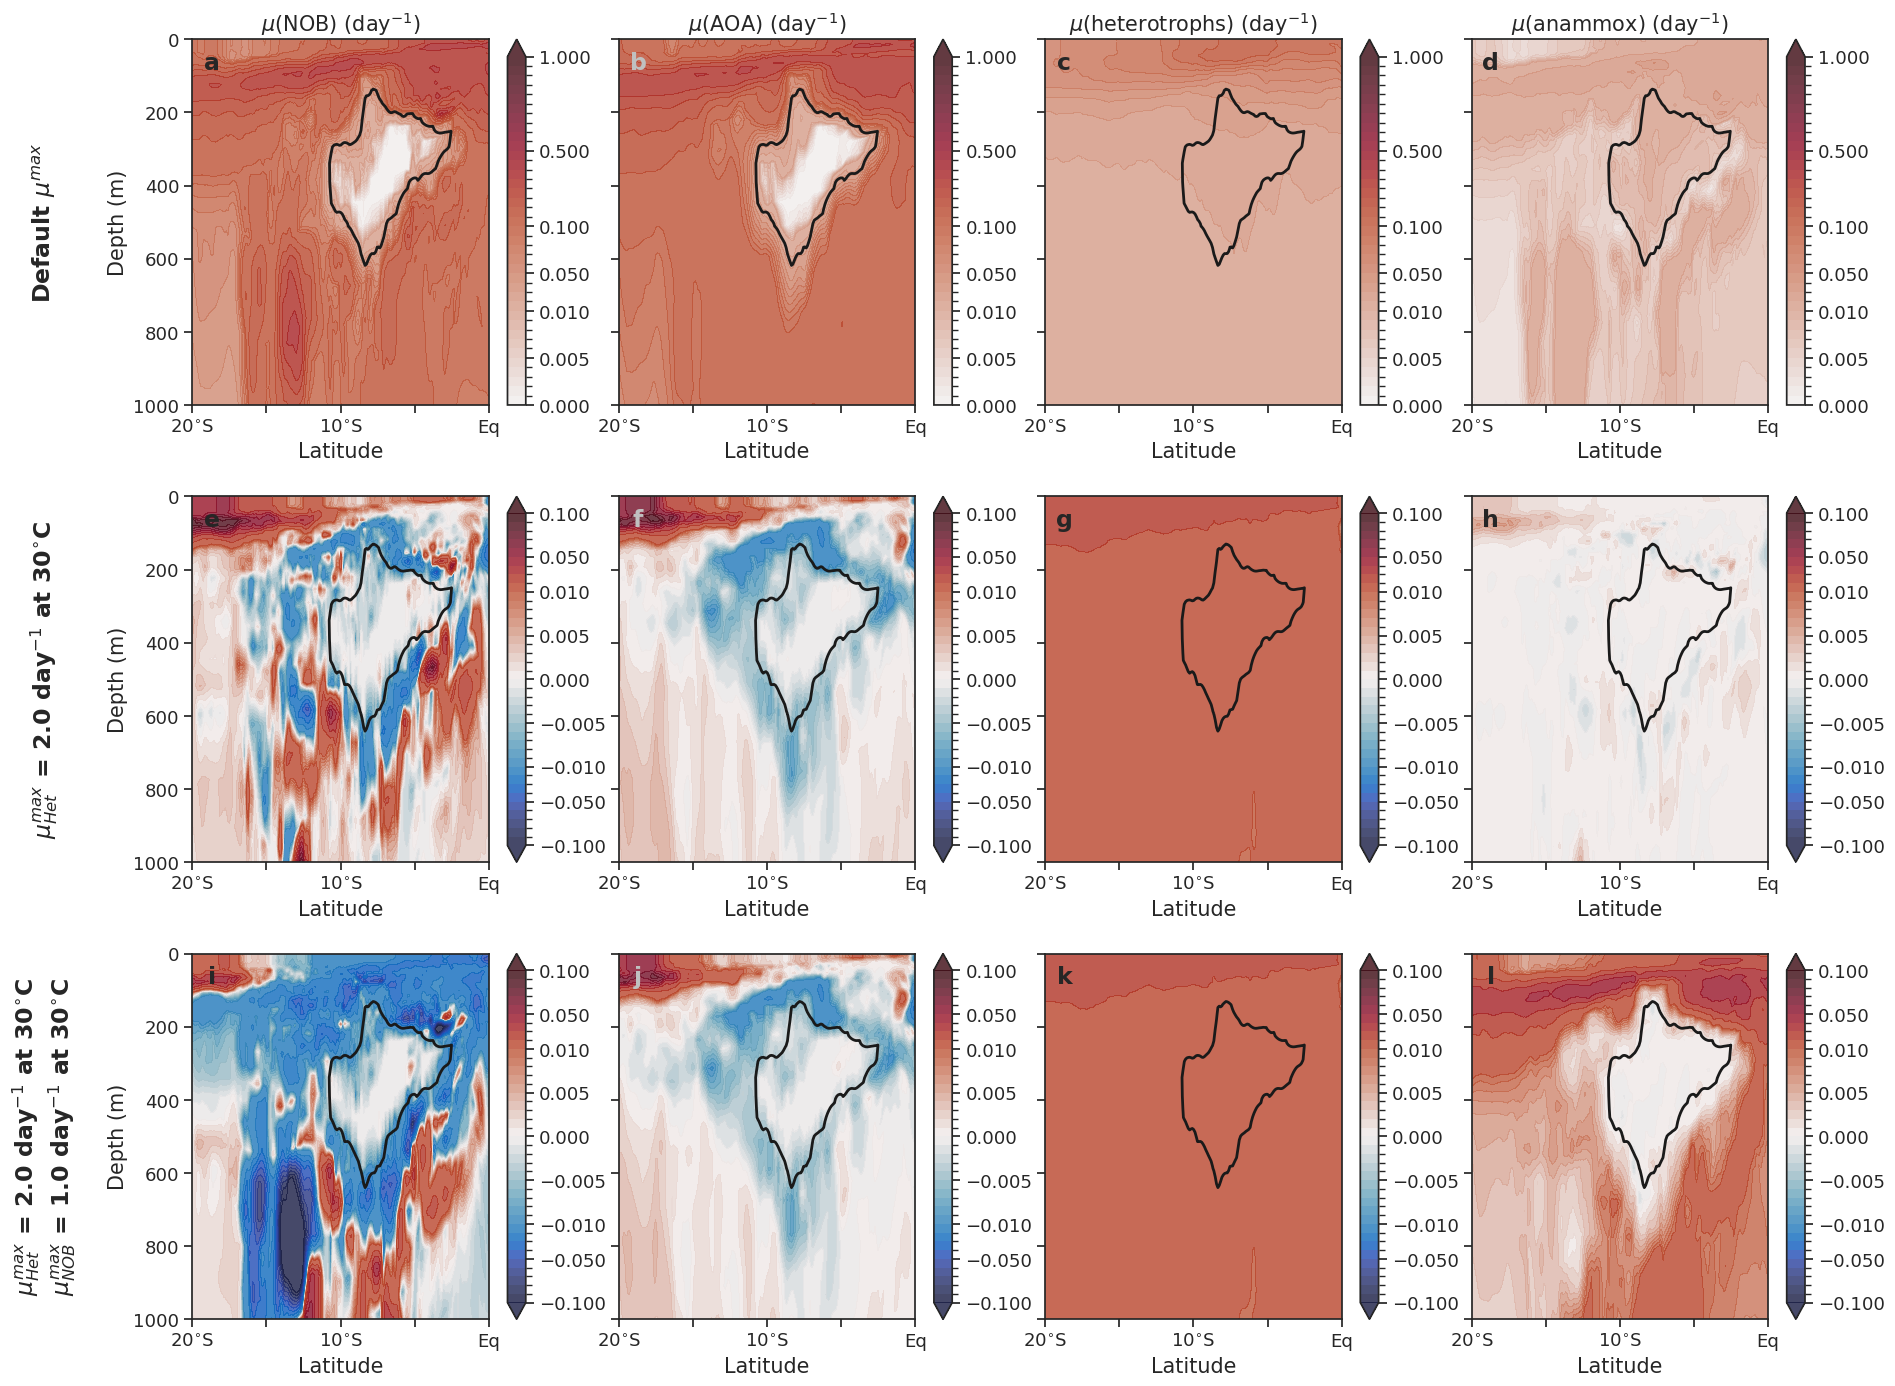

In [40]:

fig = plt.figure(facecolor='w', figsize=(20,16))
gs = GridSpec(3,4)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax12 = plt.subplot(gs[2,3])

   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_nobmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_aoamu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_hetmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_aoxmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c4 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c4o2 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p5 = ax5.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c5 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c6 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p7 = ax7.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_hetmu-norm_ytransect_hetmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c7 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_aoxmu-norm_ytransect_aoxmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c8 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c8o2 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p9 = ax9.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c9 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c9o2 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p10 = ax10.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c10 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c10o2 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p11 = ax11.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_hetmu-norm_ytransect_hetmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c11 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c11o2 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p12 = ax12.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_aoxmu-norm_ytransect_aoxmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c12 = ax12.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c12o2 = ax12.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,10,14,19,27,37]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs1[[0,5,10,14,19,27,37]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs1[[0,5,10,14,19,27,37]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs1[[0,5,10,14,19,27,37]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb9 = plt.colorbar(p9, ax=ax9, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb10 = plt.colorbar(p10, ax=ax10, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb11 = plt.colorbar(p11, ax=ax11, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb12 = plt.colorbar(p12, ax=ax12, ticks=levs2[[0,5,9,14,19,24,29,33,38]])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)
cb9.ax.tick_params(labelsize=fstic)
cb10.ax.tick_params(labelsize=fstic)
cb11.ax.tick_params(labelsize=fstic)
cb12.ax.tick_params(labelsize=fstic)

x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)
ax9.set_xlim(x1,x2)
ax9.set_ylim(y1,y2)
ax10.set_xlim(x1,x2)
ax10.set_ylim(y1,y2)
ax11.set_xlim(x1,x2)
ax11.set_ylim(y1,y2)
ax12.set_xlim(x1,x2)
ax12.set_ylim(y1,y2)

ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax4.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)
ax9.tick_params(labelsize=fstic)
ax10.tick_params(labelsize=fstic, labelleft=False)
ax11.tick_params(labelsize=fstic, labelleft=False)
ax12.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.15, right=0.975, wspace=0.15, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax4.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax6.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax7.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax8.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax9.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax9.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax10.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax11.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax12.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Latitude", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax8.set_xlabel("Latitude", fontsize=fslab)
ax9.set_ylabel("Depth (m)", fontsize=fslab)
ax9.set_xlabel("Latitude", fontsize=fslab)
ax10.set_xlabel("Latitude", fontsize=fslab)
ax11.set_xlabel("Latitude", fontsize=fslab)
ax12.set_xlabel("Latitude", fontsize=fslab)

ax1.set_title("$\mu$(NOB) (day$^{-1}$)", fontsize=fslab)
ax2.set_title("$\mu$(AOA) (day$^{-1}$)", fontsize=fslab)
ax3.set_title("$\mu$(heterotrophs) (day$^{-1}$)", fontsize=fslab)
ax4.set_title("$\mu$(anammox) (day$^{-1}$)", fontsize=fslab)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes, color='silver')
plt.text(xx,yy,'k', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax11.transAxes)
plt.text(xx,yy,'l', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax12.transAxes)


xx = -0.5; yy = 0.5
plt.text(xx,yy,'Default $\mu^{max}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax1.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax5.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax9.transAxes)


In [41]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig13-withannamox.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig13-withannamox.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig13-withannamox_transparent.png", dpi=300, transparent=True)


### this one with only Het=2 and NOB=1 (without anammox)

Text(-0.5, 0.5, '$\\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\\circ}$C\n$\\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\\circ}$C\n$\\mu^{max}_{AOA}$ = 2.0 day$^{-1}$ at 30$^{\\circ}$C')

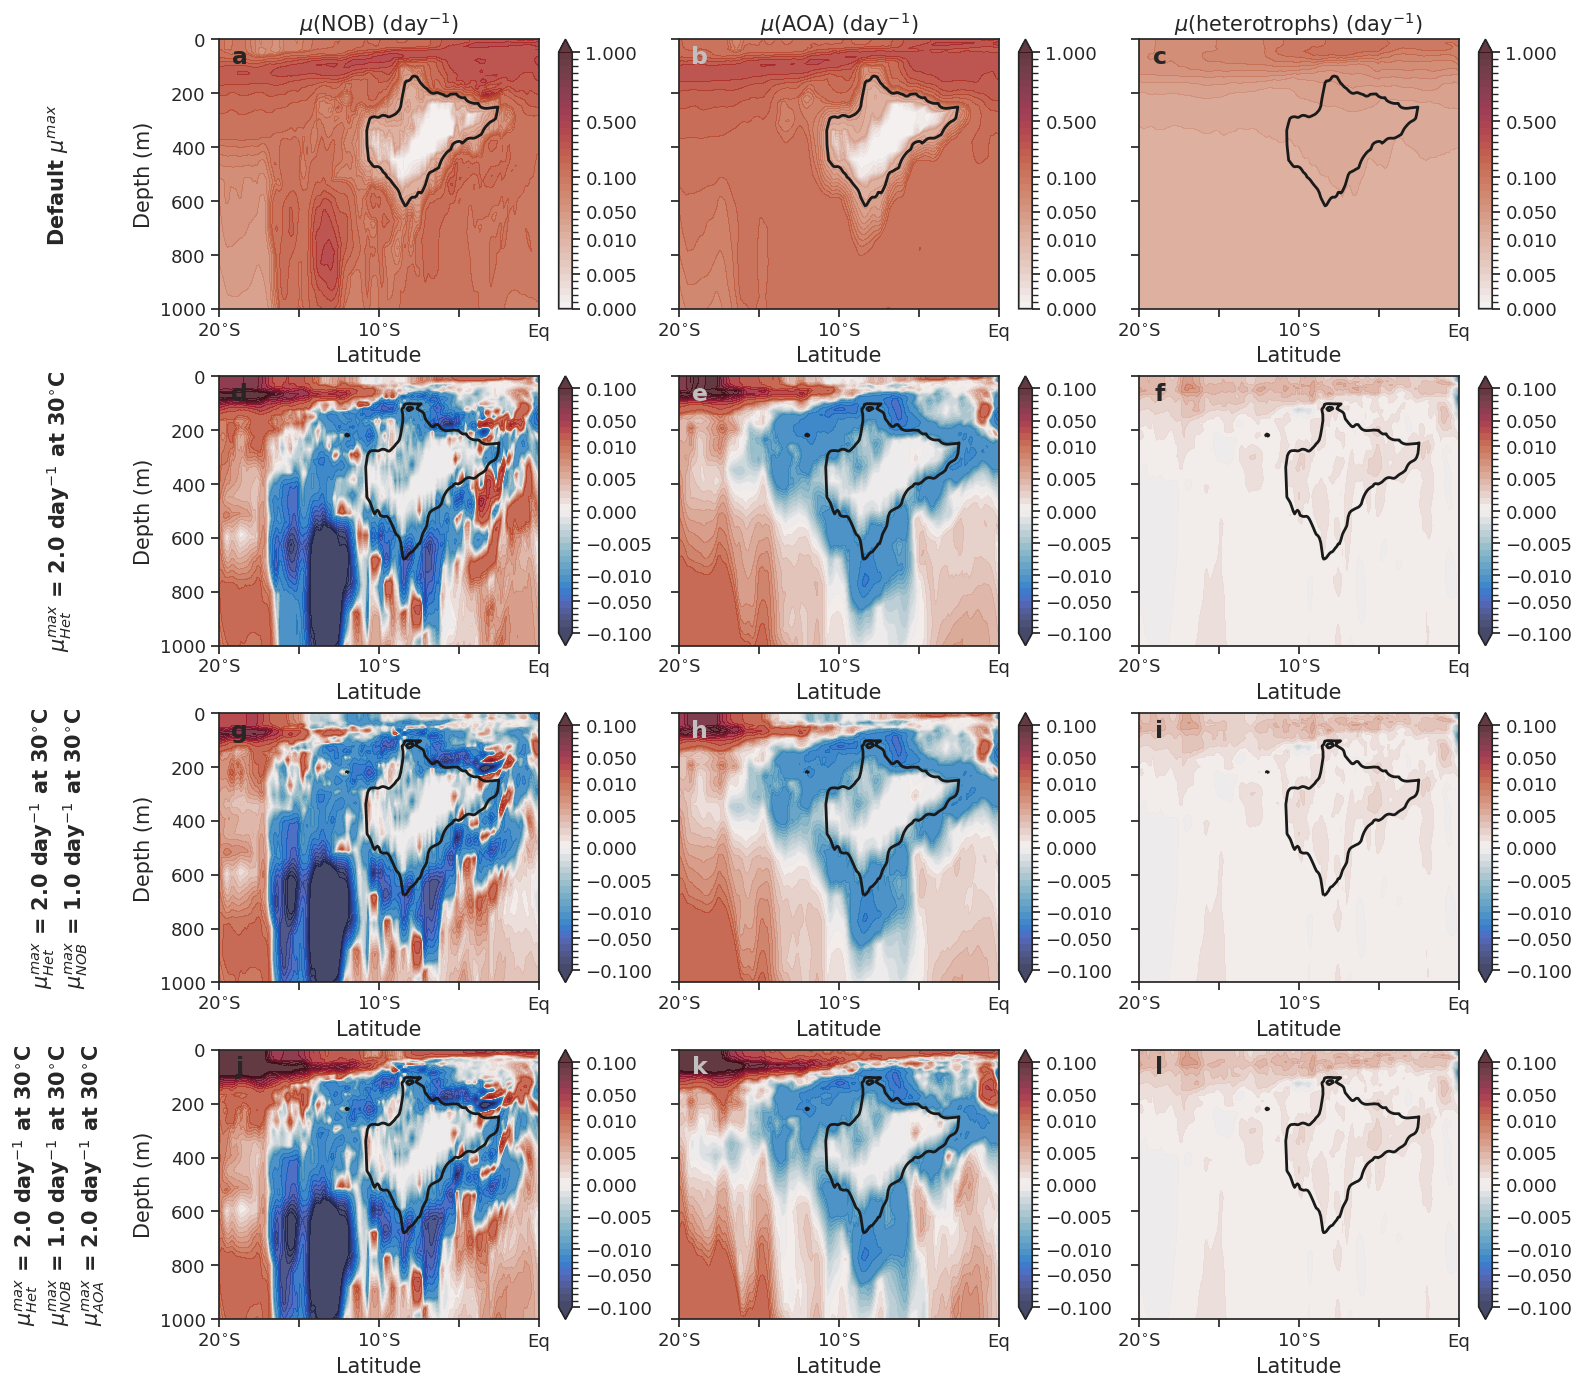

In [40]:

fig = plt.figure(facecolor='w', figsize=(16,16))
gs = GridSpec(4,3)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax13 = plt.subplot(gs[3,0])
ax14 = plt.subplot(gs[3,1])
ax15 = plt.subplot(gs[3,2])

   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_nobmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_aoamu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_hetmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p5 = ax5.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c5 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c6 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p7 = ax7.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_hetmu-norm_ytransect_hetmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c7 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p9 = ax9.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c9 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c9o2 = ax9.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p10 = ax10.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c10 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c10o2 = ax10.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p11 = ax11.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_hetmu-norm_ytransect_hetmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c11 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c11o2 = ax11.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p13 = ax13.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, (all_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c13 = ax13.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c13o2 = ax13.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p14 = ax14.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, (all_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c14 = ax14.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c14o2 = ax14.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p15 = ax15.contourf(all_ytransect_y, all_ytransect_z.mean(dim='time').values, (all_ytransect_hetmu-norm_ytransect_hetmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c15 = ax15.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c15o2 = ax15.contour(all_ytransect_y, all_ytransect_z.mean(dim='time').values, all_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)



cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,10,14,19,27,37]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs1[[0,5,10,14,19,27,37]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs1[[0,5,10,14,19,27,37]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb9 = plt.colorbar(p9, ax=ax9, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb10 = plt.colorbar(p10, ax=ax10, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb11 = plt.colorbar(p11, ax=ax11, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb13 = plt.colorbar(p13, ax=ax13, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb14 = plt.colorbar(p14, ax=ax14, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb15 = plt.colorbar(p15, ax=ax15, ticks=levs2[[0,5,9,14,19,24,29,33,38]])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb9.ax.tick_params(labelsize=fstic)
cb10.ax.tick_params(labelsize=fstic)
cb11.ax.tick_params(labelsize=fstic)
cb13.ax.tick_params(labelsize=fstic)
cb14.ax.tick_params(labelsize=fstic)
cb15.ax.tick_params(labelsize=fstic)

x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax9.set_xlim(x1,x2)
ax9.set_ylim(y1,y2)
ax10.set_xlim(x1,x2)
ax10.set_ylim(y1,y2)
ax11.set_xlim(x1,x2)
ax11.set_ylim(y1,y2)
ax13.set_xlim(x1,x2)
ax13.set_ylim(y1,y2)
ax14.set_xlim(x1,x2)
ax14.set_ylim(y1,y2)
ax15.set_xlim(x1,x2)
ax15.set_ylim(y1,y2)

ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax9.tick_params(labelsize=fstic)
ax10.tick_params(labelsize=fstic, labelleft=False)
ax11.tick_params(labelsize=fstic, labelleft=False)
ax13.tick_params(labelsize=fstic)
ax14.tick_params(labelsize=fstic, labelleft=False)
ax15.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.15, right=0.975, wspace=0.15, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax6.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax7.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax9.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax9.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax10.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax11.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax13.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax13.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax14.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax15.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Latitude", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax9.set_ylabel("Depth (m)", fontsize=fslab)
ax9.set_xlabel("Latitude", fontsize=fslab)
ax10.set_xlabel("Latitude", fontsize=fslab)
ax11.set_xlabel("Latitude", fontsize=fslab)
ax13.set_ylabel("Depth (m)", fontsize=fslab)
ax13.set_xlabel("Latitude", fontsize=fslab)
ax14.set_xlabel("Latitude", fontsize=fslab)
ax15.set_xlabel("Latitude", fontsize=fslab)

ax1.set_title("$\mu$(NOB) (day$^{-1}$)", fontsize=fslab)
ax2.set_title("$\mu$(AOA) (day$^{-1}$)", fontsize=fslab)
ax3.set_title("$\mu$(heterotrophs) (day$^{-1}$)", fontsize=fslab)

### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes, color='silver')
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax11.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax13.transAxes)
plt.text(xx,yy,'k', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax14.transAxes, color='silver')
plt.text(xx,yy,'l', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax15.transAxes)


xx = -0.5; yy = 0.5
plt.text(xx,yy,'Default $\mu^{max}$', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax1.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax5.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax9.transAxes)
plt.text(xx,yy,'$\mu^{max}_{Het}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$ at 30$^{\circ}$C\n$\mu^{max}_{AOA}$ = 2.0 day$^{-1}$ at 30$^{\circ}$C', fontweight='bold', fontsize=fslab, va='center', ha='center', rotation=90, transform=ax13.transAxes)


In [41]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig12.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig12.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig12_transparent.png", dpi=300, transparent=True)


### this one with Het=2, Het&AOA=2, and NOB=1

Text(-0.5, 0.5, '$\\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$\n$\\mu^{max}_{AOA}$ = 2.0 day$^{-1}$\n$\\mu^{max}_{NOB}$ = 1.0 day$^{-1}$')

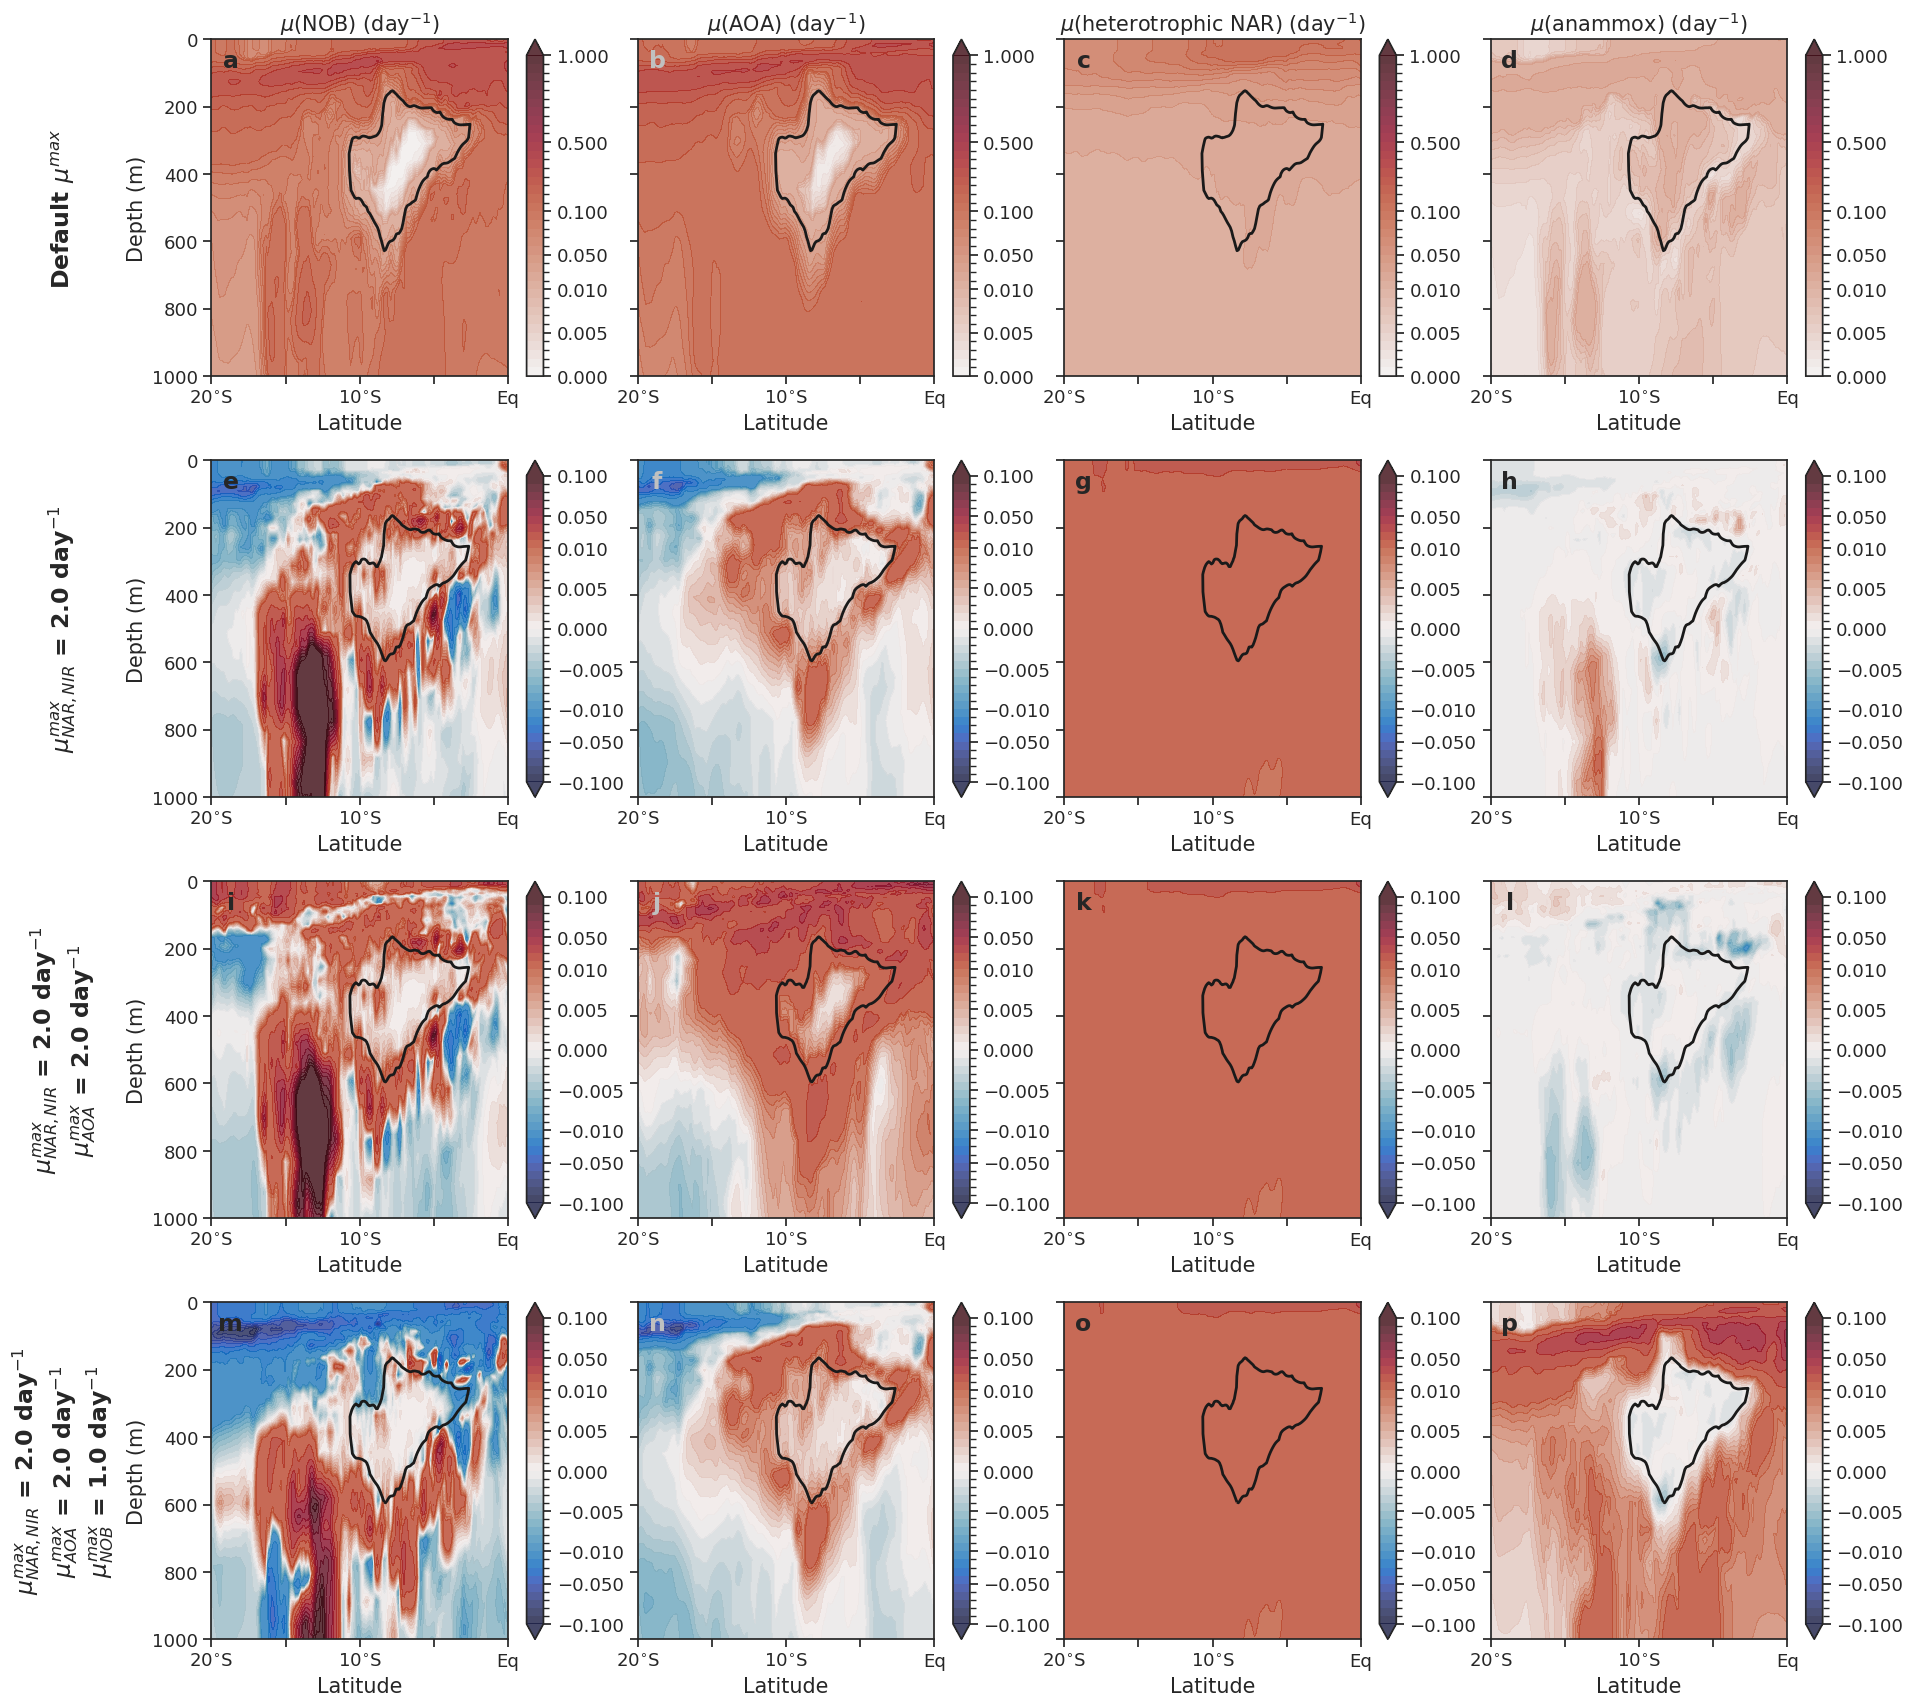

In [52]:

fig = plt.figure(facecolor='w', figsize=(20,20))
gs = GridSpec(4,4)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax12 = plt.subplot(gs[2,3])
ax13 = plt.subplot(gs[3,0])
ax14 = plt.subplot(gs[3,1])
ax15 = plt.subplot(gs[3,2])
ax16 = plt.subplot(gs[3,3])

   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_nobmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_aoamu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_narmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_aoxmu.mean(dim='time')*86400, \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
#c4 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c4o2 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p5 = ax5.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c5 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c6 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p7 = ax7.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_narmu-norm_ytransect_narmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c7 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, (het2_ytransect_aoxmu-norm_ytransect_aoxmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c8 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c8o2 = ax8.contour(het2_ytransect_y, het2_ytransect_z.mean(dim='time').values, het2_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p9 = ax9.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, (both_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c9 = ax9.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c9o2 = ax9.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p10 = ax10.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, (both_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c10 = ax10.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c10o2 = ax10.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p11 = ax11.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, (both_ytransect_narmu-norm_ytransect_narmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c11 = ax11.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c11o2 = ax11.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p12 = ax12.contourf(both_ytransect_y, both_ytransect_z.mean(dim='time').values, (both_ytransect_aoxmu-norm_ytransect_aoxmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c12 = ax12.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c12o2 = ax12.contour(both_ytransect_y, both_ytransect_z.mean(dim='time').values, both_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p13 = ax13.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_nobmu-norm_ytransect_nobmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c13 = ax13.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
#                 levels=conts1, colors=contcol, linewidths=contl1)
c13o2 = ax13.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p14 = ax14.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_aoamu-norm_ytransect_aoamu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c14 = ax14.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2cons.mean(dim='time')*86400*1e3, \
#                 levels=conts2, colors=contcol, linewidths=contl2)
c14o2 = ax14.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p15 = ax15.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_narmu-norm_ytransect_narmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c15 = ax15.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2nob.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c15o2 = ax15.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p16 = ax16.contourf(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, (nob1_ytransect_aoxmu-norm_ytransect_aoxmu).mean(dim='time')*86400, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#c16 = ax16.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2aoa.mean(dim='time'), \
#                 levels=conts3, colors=contcol, linewidths=contl3)
c16o2 = ax16.contour(nob1_ytransect_y, nob1_ytransect_z.mean(dim='time').values, nob1_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,10,14,19,27,37]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs1[[0,5,10,14,19,27,37]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs1[[0,5,10,14,19,27,37]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs1[[0,5,10,14,19,27,37]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb9 = plt.colorbar(p9, ax=ax9, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb10 = plt.colorbar(p10, ax=ax10, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb11 = plt.colorbar(p11, ax=ax11, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb12 = plt.colorbar(p12, ax=ax12, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb13 = plt.colorbar(p13, ax=ax13, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb14 = plt.colorbar(p14, ax=ax14, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb15 = plt.colorbar(p15, ax=ax15, ticks=levs2[[0,5,9,14,19,24,29,33,38]])
cb16 = plt.colorbar(p16, ax=ax16, ticks=levs2[[0,5,9,14,19,24,29,33,38]])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)
cb9.ax.tick_params(labelsize=fstic)
cb10.ax.tick_params(labelsize=fstic)
cb11.ax.tick_params(labelsize=fstic)
cb12.ax.tick_params(labelsize=fstic)
cb13.ax.tick_params(labelsize=fstic)
cb14.ax.tick_params(labelsize=fstic)
cb15.ax.tick_params(labelsize=fstic)
cb16.ax.tick_params(labelsize=fstic)


x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)
ax9.set_xlim(x1,x2)
ax9.set_ylim(y1,y2)
ax10.set_xlim(x1,x2)
ax10.set_ylim(y1,y2)
ax11.set_xlim(x1,x2)
ax11.set_ylim(y1,y2)
ax12.set_xlim(x1,x2)
ax12.set_ylim(y1,y2)
ax13.set_xlim(x1,x2)
ax13.set_ylim(y1,y2)
ax14.set_xlim(x1,x2)
ax14.set_ylim(y1,y2)
ax15.set_xlim(x1,x2)
ax15.set_ylim(y1,y2)
ax16.set_xlim(x1,x2)
ax16.set_ylim(y1,y2)


ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax4.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)
ax9.tick_params(labelsize=fstic)
ax10.tick_params(labelsize=fstic, labelleft=False)
ax11.tick_params(labelsize=fstic, labelleft=False)
ax12.tick_params(labelsize=fstic, labelleft=False)
ax13.tick_params(labelsize=fstic)
ax14.tick_params(labelsize=fstic, labelleft=False)
ax15.tick_params(labelsize=fstic, labelleft=False)
ax16.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.15, right=0.975, wspace=0.15, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax4.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax6.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax7.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax8.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax9.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax9.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax10.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax11.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax12.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax13.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax13.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax14.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax15.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax16.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Latitude", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax8.set_xlabel("Latitude", fontsize=fslab)
ax9.set_ylabel("Depth (m)", fontsize=fslab)
ax9.set_xlabel("Latitude", fontsize=fslab)
ax10.set_xlabel("Latitude", fontsize=fslab)
ax11.set_xlabel("Latitude", fontsize=fslab)
ax12.set_xlabel("Latitude", fontsize=fslab)
ax13.set_ylabel("Depth (m)", fontsize=fslab)
ax13.set_xlabel("Latitude", fontsize=fslab)
ax14.set_xlabel("Latitude", fontsize=fslab)
ax15.set_xlabel("Latitude", fontsize=fslab)
ax16.set_xlabel("Latitude", fontsize=fslab)

ax1.set_title("$\mu$(NOB) (day$^{-1}$)", fontsize=fslab)
ax2.set_title("$\mu$(AOA) (day$^{-1}$)", fontsize=fslab)
ax3.set_title("$\mu$(heterotrophic NAR) (day$^{-1}$)", fontsize=fslab)
ax4.set_title("$\mu$(anammox) (day$^{-1}$)", fontsize=fslab)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes, color='silver')
plt.text(xx,yy,'k', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax11.transAxes)
plt.text(xx,yy,'l', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax12.transAxes)
plt.text(xx,yy,'m', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax13.transAxes)
plt.text(xx,yy,'n', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax14.transAxes, color='silver')
plt.text(xx,yy,'o', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax15.transAxes)
plt.text(xx,yy,'p', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax16.transAxes)


xx = -0.5; yy = 0.5
plt.text(xx,yy,'Default $\mu^{max}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax1.transAxes)
plt.text(xx,yy,'$\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax5.transAxes)
plt.text(xx,yy,'$\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$\n$\mu^{max}_{AOA}$ = 2.0 day$^{-1}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax9.transAxes)
plt.text(xx,yy,'$\mu^{max}_{NAR,NIR}$ = 2.0 day$^{-1}$\n$\mu^{max}_{AOA}$ = 2.0 day$^{-1}$\n$\mu^{max}_{NOB}$ = 1.0 day$^{-1}$', fontweight='bold', fontsize=fslab+2, va='center', ha='center', rotation=90, transform=ax13.transAxes)


In [53]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_sensitivity_exps_mu.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_sensitivity_exps_mu.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_sensitivity_exps_mu_transparent.png", dpi=300, transparent=True)
